In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, average_precision_score,
                           classification_report, confusion_matrix)
from sklearn.ensemble import IsolationForest
from torch.utils.data import DataLoader, TensorDataset, Dataset

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [4]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [5]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

Torch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1


In [6]:
import pandas as pd

df = pd.read_parquet("cicdarknet2020.parquet", engine="fastparquet")
df.info()
df['Label'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103121 entries, 0 to 103120
Data columns (total 79 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Protocol                    103121 non-null  int8    
 1   Flow Duration               103121 non-null  int32   
 2   Total Fwd Packet            103121 non-null  int32   
 3   Total Bwd packets           103121 non-null  int32   
 4   Total Length of Fwd Packet  103121 non-null  int32   
 5   Total Length of Bwd Packet  103121 non-null  int32   
 6   Fwd Packet Length Max       103121 non-null  int32   
 7   Fwd Packet Length Min       103121 non-null  int16   
 8   Fwd Packet Length Mean      103121 non-null  float32 
 9   Fwd Packet Length Std       103121 non-null  float32 
 10  Bwd Packet Length Max       103121 non-null  int32   
 11  Bwd Packet Length Min       103121 non-null  int16   
 12  Bwd Packet Length Mean      103121 non-null  float32 
 13 

Label
Non-Tor    64804
NonVPN     20216
VPN        16922
Tor         1179
Name: count, dtype: int64

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


print("=== INITIAL DATA INSPECTION ===")
print(f"DataFrame shape: {df.shape}")
print(f"Memory usage: {df.memory_usage().sum() / 1024 / 1024:.2f} MB")

# Let's check the actual dtypes more carefully
print("\n=== DATA TYPES DETAILED ===")
print("Label column info:")
print(f"  dtype: {df['Label'].dtype}")
print(f"  type of dtype: {type(df['Label'].dtype)}")
print(f"  is categorical? {pd.api.types.is_categorical_dtype(df['Label'])}")
print(f"  is string? {pd.api.types.is_string_dtype(df['Label'])}")

print("\nLabel.1 column info:")
print(f"  dtype: {df['Label.1'].dtype}")
print(f"  type of dtype: {type(df['Label.1'].dtype)}")
print(f"  is categorical? {pd.api.types.is_categorical_dtype(df['Label.1'])}")
print(f"  is string? {pd.api.types.is_string_dtype(df['Label.1'])}")

# DECISION TIME: Which label to use?
print("\n=== DECIDING WHICH LABEL TO USE ===")
print("Based on your output:")
print("1. Label column: Has values 0, 1, 2, 3 (4 classes)")
print("2. Label.1 column: Has actual names like 'Browsing', 'P2P', etc.")

# Let me check if Label might be encoded already
print("\nChecking if Label is already encoded...")
# Get a mapping by sampling
sample_size = min(100, len(df))
sample = df[['Label', 'Label.1']].sample(sample_size)
for _, row in sample.iterrows():
    print(f"Label: {row['Label']} -> Label.1: {row['Label.1']}")



# Let's create a proper mapping
print("\n=== CREATING PROPER LABEL MAPPING ===")
# Group by Label and see what Label.1 values correspond
label_mapping_df = df.groupby('Label')['Label.1'].agg(['first', 'nunique', lambda x: list(x.unique())[:5]])
label_mapping_df.columns = ['most_common', 'num_unique', 'sample_values']
print(label_mapping_df)

# If Label is already encoded and Label.1 has the names, use Label.1
print("\nBased on analysis, I recommend using Label.1 as it has the actual class names")

# Clean up the data
print("\n=== DATA CLEANING ===")
print("Checking for duplicate columns...")
duplicate_columns = df.columns[df.columns.duplicated()]
print(f"Duplicate columns: {list(duplicate_columns)}")

# Check for constant columns
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
print(f"Constant columns: {constant_columns}")

if constant_columns:
    df = df.drop(columns=constant_columns)
    print(f"Dropped constant columns: {constant_columns}")

# Handle missing/infinite values
print("\n=== HANDLING MISSING/INFINITE VALUES ===")
numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)

nan_counts = df.isnull().sum()
if nan_counts.any():
    nan_cols = nan_counts[nan_counts > 0].index.tolist()
    print(f"Columns with NaN: {nan_cols}")
    
    for col in numeric_cols:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].median())

# Now process the labels
print("\n=== LABEL PROCESSING ===")
# Use Label.1 since it has the actual names
df['Label_original'] = df['Label.1'].astype(str)

# Clean the labels
df['Label_cleaned'] = df['Label_original'].str.lower().str.strip()

# Check cleaned labels
print("\nCleaned label distribution:")
cleaned_counts = df['Label_cleaned'].value_counts()
for label, count in cleaned_counts.items():
    proportion = count / len(df) * 100
    print(f"  '{label}': {count} samples ({proportion:.2f}%)")

# Encode labels
label_encoder = LabelEncoder()
df['Label_encoded'] = label_encoder.fit_transform(df['Label_cleaned'])

print("\n=== FINAL LABEL ENCODING ===")
print("Class mapping:")
for i, label in enumerate(label_encoder.classes_):
    count = (df['Label_cleaned'] == label).sum()
    proportion = count / len(df) * 100
    print(f"  {i}: '{label}' - {count} samples ({proportion:.2f}%)")

label_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))

# Prepare features
print("\n=== FEATURE PREPARATION ===")
# Exclude all label-related columns
label_cols = ['Label', 'Label.1', 'Label_original', 'Label_cleaned', 'Label_encoded']
exclude_cols = [col for col in label_cols if col in df.columns]

feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols]
y = df['Label_encoded']

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Scale features
print("\n=== FEATURE SCALING ===")
scaler = StandardScaler()
X_scaled = X.copy()
numeric_features = X.select_dtypes(include=[np.number]).columns

if len(numeric_features) > 0:
    X_scaled[numeric_features] = scaler.fit_transform(X[numeric_features])
    print(f"Scaled {len(numeric_features)} numeric features")
else:
    print("No numeric features to scale")

# Split data
print("\n=== DATA SPLITTING ===")
class_counts = y.value_counts()
print("Class distribution:")
for class_id, count in class_counts.items():
    class_name = label_encoder.inverse_transform([class_id])[0]
    proportion = count / len(y) * 100
    print(f"  {class_id}: '{class_name}' - {count} samples ({proportion:.2f}%)")

# Use stratification if possible
if class_counts.min() >= 2:
    print("\nUsing stratified split")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
else:
    print("\nUsing random split (some classes have < 2 samples)")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Save processed data
print("\n=== SAVING DATA ===")
import pickle
from datetime import datetime

preprocessed_data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'feature_names': X_train.columns.tolist(),
    'label_mapping': label_mapping,
    'num_classes': len(label_encoder.classes_)
}




#Quick Summary 
print("\nData preprocessing completed successfully.")   

=== INITIAL DATA INSPECTION ===
DataFrame shape: (103121, 79)
Memory usage: 23.60 MB

=== DATA TYPES DETAILED ===
Label column info:
  dtype: category
  type of dtype: <class 'pandas.core.dtypes.dtypes.CategoricalDtype'>
  is categorical? True
  is string? True

Label.1 column info:
  dtype: category
  type of dtype: <class 'pandas.core.dtypes.dtypes.CategoricalDtype'>
  is categorical? True
  is string? True

=== DECIDING WHICH LABEL TO USE ===
Based on your output:
1. Label column: Has values 0, 1, 2, 3 (4 classes)
2. Label.1 column: Has actual names like 'Browsing', 'P2P', etc.

Checking if Label is already encoded...
Label: Non-Tor -> Label.1: P2P
Label: Non-Tor -> Label.1: Browsing
Label: VPN -> Label.1: Audio-Streaming
Label: Non-Tor -> Label.1: Browsing
Label: VPN -> Label.1: Chat
Label: NonVPN -> Label.1: Chat
Label: NonVPN -> Label.1: Audio-Streaming
Label: Non-Tor -> Label.1: Browsing
Label: Non-Tor -> Label.1: P2P
Label: Tor -> Label.1: VOIP
Label: Non-Tor -> Label.1: Browsi

In [8]:
df['is_encrypted'] = df['Label'].apply(lambda x: 1 if x in ['Tor','VPN'] else 0)
df['is_encrypted'] = df['is_encrypted'].astype(int)
df['is_encrypted'].value_counts()
X = df.drop(columns=['Label', 'is_encrypted'])
y_multiclass = df['Label']         # for multiclass classification
y_binary = df['is_encrypted']      # for encrypted vs non-encrypted

In [9]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np

# Assuming df['Label_encoded'] exists
X = X_scaled  # scaled numeric features
y = df['Label_encoded'].values  # integer-encoded labels

# Split train/test (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_binary
)

print("Class distribution before SMOTE:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c} samples")

# Apply SMOTE to training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE:")
unique_res, counts_res = np.unique(y_train_res, return_counts=True)
for u, c in zip(unique_res, counts_res):
    print(f"  Class {u}: {c} samples")


Class distribution before SMOTE:
  Class 0: 8987 samples
  Class 1: 23732 samples
  Class 2: 8321 samples
  Class 3: 4405 samples
  Class 4: 8603 samples
  Class 5: 18782 samples
  Class 6: 7206 samples
  Class 7: 2460 samples

Class distribution after SMOTE:
  Class 0: 23732 samples
  Class 1: 23732 samples
  Class 2: 23732 samples
  Class 3: 23732 samples
  Class 4: 23732 samples
  Class 5: 23732 samples
  Class 6: 23732 samples
  Class 7: 23732 samples


In [10]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np

# Binary target
y_binary = df['is_encrypted'].values  # 0 = non-encrypted, 1 = Tor/VPN

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_binary, 
    test_size=0.2, 
    random_state=42,
    stratify=y_binary
)


print("Class distribution before SMOTE (binary):")
unique, counts = np.unique(y_binary, return_counts=True)
for u, c in zip(unique, counts):
    label_name = "Encrypted" if u == 1 else "Non-encrypted"
    print(f"  {label_name}: {c} samples")

# Apply SMOTE to training set
smote_bin = SMOTE(random_state=42)
X_train_bin_res, y_train_bin_res = smote_bin.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE (binary):")
unique_res, counts_res = np.unique(y_train_bin_res, return_counts=True)
for u, c in zip(unique_res, counts_res):
    label_name = "Encrypted" if u == 1 else "Non-encrypted"
    print(f"  {label_name}: {c} samples")


Class distribution before SMOTE (binary):
  Non-encrypted: 85020 samples
  Encrypted: 18101 samples

Class distribution after SMOTE (binary):
  Non-encrypted: 68015 samples
  Encrypted: 68015 samples


In [11]:
# Train IF on all training data (or only normal traffic if you have labels)
if_model = IsolationForest(n_estimators=200, contamination=0.03, random_state=42)
if_model.fit(X_train)

# Get anomaly scores (more negative = more anomalous)
if_scores_train = if_model.decision_function(X_train)
if_scores_test = if_model.decision_function(X_test)

# Add IF score as an additional feature
X_train_if = np.hstack([X_train, if_scores_train.reshape(-1,1)])
X_test_if = np.hstack([X_test, if_scores_test.reshape(-1,1)])


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_binary, 
    test_size=0.2, 
    random_state=42,
    stratify=y_binary
)

print("Train encrypted count:", sum(y_train))
print("Test encrypted count:", sum(y_test))

print("Unique values in y_binary:", np.unique(y_binary))



Train encrypted count: 14481
Test encrypted count: 3620
Unique values in y_binary: [0 1]


In [13]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import IsolationForest
import numpy as np

# Train IF only on normal samples (y_train == 0)
if_model = IsolationForest(contamination=0.05, random_state=42)
if_model.fit(X_train[y_train == 0])

# anomaly scores (more negative = more anomalous)
if_scores_train = -if_model.decision_function(X_train)
if_scores_test = -if_model.decision_function(X_test)

# pick threshold = 95th percentile of normal scores
threshold_if = np.percentile(if_scores_train[y_train == 0], 95)
if_pred = (if_scores_test > threshold_if).astype(int)

print("\n=== ISOLATION FOREST ===")
print("Accuracy:", accuracy_score(y_test, if_pred))
print("ROC-AUC:", roc_auc_score(y_test, if_scores_test))
print("Precision:", precision_score(y_test, if_pred))
print("Recall:", recall_score(y_test, if_pred))
print("F1-score:", f1_score(y_test, if_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, if_pred))



=== ISOLATION FOREST ===
Accuracy: 0.8000484848484849
ROC-AUC: 0.6621479220443776
Precision: 0.28716216216216217
Recall: 0.09392265193370165
F1-score: 0.14154870940882597
Confusion Matrix:
 [[16161   844]
 [ 3280   340]]


In [17]:
X_train_if = np.hstack([X_train, if_scores_train.reshape(-1,1)])
X_test_if = np.hstack([X_test, if_scores_test.reshape(-1,1)])
from tensorflow.keras import layers, models, Model
# 1️⃣ Prepare data
X_train_if = np.hstack([X_train, if_scores_train.reshape(-1,1)])
X_test_if  = np.hstack([X_test, if_scores_test.reshape(-1,1)])
input_dim = X_train_if.shape[1]

# 2️⃣ Define autoencoder
input_layer = layers.Input(shape=(input_dim,))
x = layers.Dense(64, activation='relu')(input_layer)
x = layers.Dense(32, activation='relu')(x)
latent = layers.Dense(16, activation='relu')(x)
x = layers.Dense(32, activation='relu')(latent)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(input_dim, activation='linear')(x)
autoencoder = Model(input_layer, output)
autoencoder.compile(optimizer='adam', loss='mse')

# 3️⃣ Train autoencoder
autoencoder.fit(
    X_train_if[y_train == 0], X_train_if[y_train == 0],
    epochs=30,
    batch_size=256,
    validation_split=0.1,
    verbose=1
)

# 4️⃣ Predict reconstruction for test set
X_test_pred = autoencoder.predict(X_test_if)

# 5️⃣ Compute reconstruction error
reconstruction_error = np.mean(np.square(X_test_if - X_test_pred), axis=1)

# 5️⃣ Compute reconstruction error
reconstruction_error = np.mean(np.square(X_test_if - X_test_pred), axis=1)

Epoch 1/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5208 - val_loss: 0.3395
Epoch 2/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2251 - val_loss: 0.2094
Epoch 3/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1634 - val_loss: 0.1612
Epoch 4/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1383 - val_loss: 0.1413
Epoch 5/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1149 - val_loss: 0.1251
Epoch 6/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1021 - val_loss: 0.1302
Epoch 7/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0946 - val_loss: 0.1034
Epoch 8/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0856 - val_loss: 0.1022
Epoch 9/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0768 - val_loss: 0.1252
Epoch 10/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0743 - val_loss: 0.0899
Epoch 11/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0672 - val_loss: 0.1009
Epoch 12/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [18]:
X_test_pred = autoencoder.predict(X_test_if)
test_rec_err = np.mean((X_test_if - X_test_pred)**2, axis=1)

X_train_pred = autoencoder.predict(X_train_if[y_train == 0])
train_rec_err = np.mean((X_train_if[y_train == 0] - X_train_pred)**2, axis=1)

threshold_ae = np.percentile(train_rec_err, 95)
ae_pred = (test_rec_err > threshold_ae).astype(int)
print("\n=== AUTOENCODER ===")
print("Accuracy:", accuracy_score(y_test, ae_pred))
print("ROC-AUC:", roc_auc_score(y_test, test_rec_err))
print("Precision:", precision_score(y_test, ae_pred))
print("Recall:", recall_score(y_test, ae_pred))
print("F1-score:", f1_score(y_test, ae_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, ae_pred))


645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step
2126/2126 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step

=== AUTOENCODER ===
Accuracy: 0.8111515151515152
ROC-AUC: 0.6312620272555521
Precision: 0.40575736806031526
Recall: 0.16353591160220995
F1-score: 0.2331167552667848
Confusion Matrix:
 [[16138   867]
 [ 3028   592]]


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Deep SVDD implementation in PyTorch
# --- Encoder network (small MLP) ---
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden=[128,64], out_dim=32):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            prev = h
        layers.append(nn.Linear(prev, out_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# --- Deep SVDD trainer ---
class DeepSVDD:
    def __init__(self, input_dim, c=None, nu=0.1, lr=1e-3):
        self.encoder = Encoder(input_dim).to(device)
        self.c = c  # center (torch tensor) or None -> init from data
        self.nu = nu
        self.optimizer = optim.Adam(self.encoder.parameters(), lr=lr)
        self.criterion = lambda z, c: ((z - c)**2).sum(dim=1)  # per-sample squared dist

    def init_center_c(self, loader):
        # initialize center as mean of encoder outputs on normal data
        self.encoder.eval()
        n = 0
        c_sum = None
        with torch.no_grad():
            for x in loader:
                x = x[0].to(device).float()
                z = self.encoder(x)
                if c_sum is None:
                    c_sum = z.sum(dim=0)
                else:
                    c_sum += z.sum(dim=0)
                n += z.size(0)
        c = c_sum / n
        # avoid components too close to zero
        c[(abs(c) < 1e-6)] = 1e-6
        self.c = c

    def train(self, loader, epochs=50):
        if self.c is None:
            self.init_center_c(loader)
        self.encoder.train()
        for ep in range(epochs):
            epoch_loss = 0.0
            for x, in loader:
                x = x.to(device).float()
                z = self.encoder(x)
                dist = self.criterion(z, self.c)
                loss = dist.mean()  # minimize avg distance of normal samples
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() * x.size(0)
            # print progress
            if ep % 5 == 0:
                print(f"DeepSVDD epoch {ep}/{epochs} loss: {epoch_loss/len(loader.dataset):.6f}")

    def score(self, X):  # X: numpy array
        self.encoder.eval()
        ds = TensorDataset(torch.from_numpy(X).float())
        loader = DataLoader(ds, batch_size=1024, shuffle=False)
        scores = []
        with torch.no_grad():
            for batch in loader:
                x = batch[0].to(device)
                z = self.encoder(x)
                dist = ((z - self.c) ** 2).sum(dim=1)  # per-sample
                scores.append(dist.cpu().numpy())
        return np.concatenate(scores)


In [21]:
# Train DeepSVDD on *normal* training samples only (y_train==0)
# Convert DataFrame → NumPy → Tensor
X_train_normal_np = X_train[y_train == 0].to_numpy().astype("float32")
X_test_np = X_test.to_numpy().astype("float32")


ds = TensorDataset(torch.from_numpy(X_train_normal_np).float())
loader = DataLoader(ds, batch_size=1024, shuffle=True)

svdd = DeepSVDD(input_dim=X_train.shape[1])
svdd.init_center_c(DataLoader(TensorDataset(torch.from_numpy(X_train_normal_np).float()), batch_size=1024))
svdd.train(loader, epochs=50)

# get scores on test set (higher = more anomalous)
# Convert X_test and X_train to NumPy arrays
X_test_np = X_test.to_numpy().astype("float32")
X_train_np = X_train.to_numpy().astype("float32")

# Then score
svdd_scores_test = svdd.score(X_test_np)
svdd_scores_train = svdd.score(X_train_np)  # optional for thresholding
 # optional for thresholding


DeepSVDD epoch 0/50 loss: 0.016185
DeepSVDD epoch 5/50 loss: 0.000109
DeepSVDD epoch 10/50 loss: 0.000032
DeepSVDD epoch 15/50 loss: 0.000010
DeepSVDD epoch 20/50 loss: 0.000005
DeepSVDD epoch 25/50 loss: 0.000003
DeepSVDD epoch 30/50 loss: 0.000002
DeepSVDD epoch 35/50 loss: 0.000002
DeepSVDD epoch 40/50 loss: 0.000001
DeepSVDD epoch 45/50 loss: 0.000001


In [ ]:
# # Threshold for binary prediction
# # Usually you can set it based on 95th percentile of training normal scores
# threshold = np.percentile(svdd_scores_train[y_train == 0], 95)
# svdd_pred = (svdd_scores_test > threshold).astype(int)

# # Evaluation metrics
# y_test_binary = (y_test != 0).astype(int)  # treat all non-normal as anomaly
# print("=== DeepSVDD ===")
# print(f"Accuracy: {accuracy_score(y_test_binary, svdd_pred):.4f}")
# print(f"ROC-AUC: {roc_auc_score(y_test_binary, svdd_scores_test):.4f}")
# print(f"Precision: {precision_score(y_test_binary, svdd_pred):.4f}")
# print(f"Recall: {recall_score(y_test_binary, svdd_pred):.4f}")
# print(f"F1-score: {f1_score(y_test_binary, svdd_pred):.4f}")
# print("Confusion Matrix:")
# print(confusion_matrix(y_test_binary, svdd_pred))

=== DeepSVDD ===
Accuracy: 0.8067
ROC-AUC: 0.5375
Precision: 0.3761
Recall: 0.1539
F1-score: 0.2184
Confusion Matrix:
[[16081   924]
 [ 3063   557]]


In [ ]:
# import numpy as np
# from sklearn.ensemble import IsolationForest, RandomForestClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# from tensorflow.keras import layers, Model
# import torch
# from torch.utils.data import DataLoader, TensorDataset

# # =========================
# # 1️⃣ Base model: Isolation Forest
# # =========================
# if_model = IsolationForest(contamination=0.05, random_state=42)
# if_model.fit(X_train[y_train == 0])  # train only on normal samples

# # anomaly scores (more negative = more anomalous)
# if_scores_train = -if_model.decision_function(X_train)
# if_scores_test  = -if_model.decision_function(X_test)

# # =========================
# # 2️⃣ Base model: Autoencoder
# # =========================
# # Add IF score as extra feature
# X_train_if = np.hstack([X_train, if_scores_train.reshape(-1,1)])
# X_test_if  = np.hstack([X_test, if_scores_test.reshape(-1,1)])
# input_dim = X_train_if.shape[1]

# # Define AE
# input_layer = layers.Input(shape=(input_dim,))
# x = layers.Dense(64, activation='relu')(input_layer)
# x = layers.Dense(32, activation='relu')(x)
# latent = layers.Dense(16, activation='relu')(x)
# x = layers.Dense(32, activation='relu')(latent)
# x = layers.Dense(64, activation='relu')(x)
# output = layers.Dense(input_dim, activation='linear')(x)
# autoencoder = Model(input_layer, output)
# autoencoder.compile(optimizer='adam', loss='mse')

# # Train AE only on normal samples
# autoencoder.fit(
#     X_train_if[y_train == 0], X_train_if[y_train == 0],
#     epochs=40,
#     batch_size=256,
#     validation_split=0.1,
#     verbose=1
# )

# # AE reconstruction error
# X_train_pred = autoencoder.predict(X_train_if)
# X_test_pred  = autoencoder.predict(X_test_if)
# reconstruction_error_train = np.mean(np.square(X_train_if - X_train_pred), axis=1)
# reconstruction_error_test  = np.mean(np.square(X_test_if - X_test_pred), axis=1)

# # CNN based Autoencoder can also be used for better performance
# import numpy as np

# # Convert to 3D tensor for 1D CNN: (samples, timesteps, channels)
# X_train_cnn = X_train_if.reshape(X_train_if.shape[0], X_train_if.shape[1], 1)
# X_test_cnn  = X_test_if.reshape(X_test_if.shape[0], X_test_if.shape[1], 1)

# y_train_cnn = y_train
# y_test_cnn  = y_test

# input_layer = layers.Input(shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))
# x = layers.Conv1D(32, kernel_size=3, activation='relu')(input_layer)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Conv1D(16, kernel_size=3, activation='relu')(x)
# x = layers.Flatten()(x)
# latent = layers.Dense(16, activation='relu')(x)
# output = layers.Dense(1, activation='sigmoid')(latent)

# cnn_model = models.Model(input_layer, output)
# cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# cnn_model = Model(input_layer, output)
# cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# cnn_model.fit(
#     X_train_cnn[y_train==0], y_train_cnn[y_train==0],  # semi-supervised if you want
#     epochs=20,
#     batch_size=256,
#     validation_split=0.1,
#     verbose=1
# )
# cnn_scores_train = cnn_model.predict(X_train_cnn).flatten()
# cnn_scores_test  = cnn_model.predict(X_test_cnn).flatten()

# # =========================
# # 3️⃣ Base model: Deep SVDD
# # =========================
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# class Encoder(torch.nn.Module):
#     def __init__(self, input_dim, hidden=[128,64], out_dim=32):
#         super().__init__()
#         layers_list = []
#         prev = input_dim
#         for h in hidden:
#             layers_list.append(torch.nn.Linear(prev, h))
#             layers_list.append(torch.nn.ReLU())
#             prev = h
#         layers_list.append(torch.nn.Linear(prev, out_dim))
#         self.net = torch.nn.Sequential(*layers_list)
#     def forward(self, x):
#         return self.net(x)

# class DeepSVDD:
#     def __init__(self, input_dim, c=None, nu=0.1, lr=1e-3):
#         self.encoder = Encoder(input_dim).to(device)
#         self.c = c
#         self.nu = nu
#         self.optimizer = torch.optim.Adam(self.encoder.parameters(), lr=lr)
#         self.criterion = lambda z, c: ((z - c)**2).sum(dim=1)

#     def init_center_c(self, loader):
#         self.encoder.eval()
#         n = 0
#         c_sum = None
#         with torch.no_grad():
#             for x in loader:
#                 x = x[0].to(device).float()
#                 z = self.encoder(x)
#                 c_sum = z.sum(dim=0) if c_sum is None else c_sum + z.sum(dim=0)
#                 n += z.size(0)
#         c = c_sum / n
#         c[(abs(c) < 1e-6)] = 1e-6
#         self.c = c

#     def train(self, loader, epochs=50):
#         if self.c is None:
#             self.init_center_c(loader)
#         self.encoder.train()
#         for ep in range(epochs):
#             epoch_loss = 0.0
#             for x, in loader:
#                 x = x.to(device).float()
#                 z = self.encoder(x)
#                 dist = self.criterion(z, self.c)
#                 loss = dist.mean()
#                 self.optimizer.zero_grad()
#                 loss.backward()
#                 self.optimizer.step()
#                 epoch_loss += loss.item() * x.size(0)
#             if ep % 5 == 0:
#                 print(f"DeepSVDD epoch {ep}/{epochs} loss: {epoch_loss/len(loader.dataset):.6f}")

#     def score(self, X):  # X must be np.ndarray
#         self.encoder.eval()
#         ds = TensorDataset(torch.from_numpy(X).float())
#         loader = DataLoader(ds, batch_size=1024, shuffle=False)
#         scores = []
#         with torch.no_grad():
#             for batch in loader:
#                 x = batch[0].to(device)
#                 z = self.encoder(x)
#                 dist = ((z - self.c)**2).sum(dim=1)
#                 scores.append(dist.cpu().numpy())
#         return np.concatenate(scores)

# # Train DeepSVDD
# X_train_normal_np = X_train_if[y_train == 0].astype("float32")
# loader = DataLoader(TensorDataset(torch.from_numpy(X_train_normal_np).float()), batch_size=1024, shuffle=True)
# svdd = DeepSVDD(input_dim=input_dim)
# svdd.init_center_c(loader)
# svdd.train(loader, epochs=50)

# svdd_scores_train = svdd.score(X_train_if.astype("float32"))
# svdd_scores_test  = svdd.score(X_test_if.astype("float32"))
# from scipy.stats import zscore

# # Z-score normalization
# if_scores_train_z = zscore(if_scores_train)
# reconstruction_error_train_z = zscore(reconstruction_error_train)
# if_scores_test_z = zscore(if_scores_test)
# reconstruction_error_test_z = zscore(reconstruction_error_test)

# # Stack meta-features
# X_meta_train = np.vstack([
#     if_scores_train,
#     if_scores_train_z,
#     reconstruction_error_train,
#     reconstruction_error_train_z,
#     svdd_scores_train
# ]).T

# X_meta_test = np.vstack([
#     if_scores_test,
#     if_scores_test_z,
#     reconstruction_error_test,
#     reconstruction_error_test_z,
#     svdd_scores_test
# ]).T

# y_meta_train = y_train  # binary labels
# y_meta_test  = y_test

# # =========================
# # 4️⃣ Stacking ensemble
# # =========================
# X_meta_train = np.vstack([if_scores_train, reconstruction_error_train, svdd_scores_train, cnn_scores_train]).T
# X_meta_test  = np.vstack([if_scores_test, reconstruction_error_test, svdd_scores_test, cnn_scores_test]).T
# y_meta_train = y_train
# y_meta_test  = y_test

# from sklearn.metrics import precision_recall_curve



# meta_model = RandomForestClassifier(n_estimators=200, random_state=42)

# meta_model.fit(X_meta_train, y_meta_train)
# meta_pred = meta_model.predict(X_meta_test)

# print("=== Stacking Ensemble (Random Forest) ===")
# print(f"Accuracy: {accuracy_score(y_meta_test, meta_pred):.4f}")
# print(f"Precision: {precision_score(y_meta_test, meta_pred):.4f}")
# print(f"Recall: {recall_score(y_meta_test, meta_pred):.4f}")
# print(f"F1-score: {f1_score(y_meta_test, meta_pred):.4f}")
# print("Confusion Matrix:\n", confusion_matrix(y_meta_test, meta_pred))


Epoch 1/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5301 - val_loss: 0.3875
Epoch 2/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2390 - val_loss: 0.2016
Epoch 3/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1792 - val_loss: 0.1800
Epoch 4/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1532 - val_loss: 0.1555
Epoch 5/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1262 - val_loss: 0.1799
Epoch 6/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1233 - val_loss: 0.1379
Epoch 7/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1077 - val_loss: 0.1748
Epoch 8/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1106 - val_loss: 0.1154
Epoch 9/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0997 - val_loss: 0.1124
Epoch 10/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0849 - val_loss: 0.1509
Epoch 11/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0830 - val_loss: 0.1030
Epoch 12/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [ ]:
# import xgboost as xgb
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# # Gradient Boosting meta-classifier
# xgb_model = xgb.XGBClassifier(
#     n_estimators=200,
#     max_depth=3,
#     learning_rate=0.1,
#     random_state=42,
#     use_label_encoder=False,
#     eval_metric='logloss'
# )

# # Option 1: Train XGBoost on the same meta-features
# xgb_model.fit(X_meta_train, y_meta_train)
# xgb_pred = xgb_model.predict(X_meta_test)

# print("=== Stacking Ensemble (XGBoost on meta-features) ===")
# print(f"Accuracy: {accuracy_score(y_meta_test, xgb_pred):.4f}")
# print(f"Precision: {precision_score(y_meta_test, xgb_pred):.4f}")
# print(f"Recall: {recall_score(y_meta_test, xgb_pred):.4f}")
# print(f"F1-score: {f1_score(y_meta_test, xgb_pred):.4f}")
# print("Confusion Matrix:\n", confusion_matrix(y_meta_test, xgb_pred))


=== Stacking Ensemble (XGBoost on meta-features) ===
Accuracy: 0.9114
Precision: 0.8238
Recall: 0.6301
F1-score: 0.7140
Confusion Matrix:
 [[16517   488]
 [ 1339  2281]]


In [ ]:
# import numpy as np
# from sklearn.ensemble import IsolationForest, RandomForestClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# from tensorflow.keras import layers, Model
# import torch
# from torch.utils.data import DataLoader, TensorDataset
# import xgboost as xgb
# from scipy.stats import zscore

# # =========================
# # 1️⃣ Base model: Isolation Forest
# # =========================
# if_model = IsolationForest(contamination=0.05, random_state=42)
# if_model.fit(X_train[y_train == 0])  # train only on normal samples

# # anomaly scores
# if_scores_train = -if_model.decision_function(X_train)
# if_scores_test  = -if_model.decision_function(X_test)

# # =========================
# # 2️⃣ Base model: Autoencoder
# # =========================
# X_train_if = np.hstack([X_train, if_scores_train.reshape(-1,1)])
# X_test_if  = np.hstack([X_test, if_scores_test.reshape(-1,1)])
# input_dim = X_train_if.shape[1]

# input_layer = layers.Input(shape=(input_dim,))
# x = layers.Dense(64, activation='relu')(input_layer)
# x = layers.Dense(32, activation='relu')(x)
# latent = layers.Dense(16, activation='relu')(x)
# x = layers.Dense(32, activation='relu')(latent)
# x = layers.Dense(64, activation='relu')(x)
# output = layers.Dense(input_dim, activation='linear')(x)
# autoencoder = Model(input_layer, output)
# autoencoder.compile(optimizer='adam', loss='mse')

# autoencoder.fit(
#     X_train_if[y_train == 0], X_train_if[y_train == 0],
#     epochs=40, batch_size=256, validation_split=0.1, verbose=1
# )

# X_train_pred = autoencoder.predict(X_train_if)
# X_test_pred  = autoencoder.predict(X_test_if)
# reconstruction_error_train = np.mean(np.square(X_train_if - X_train_pred), axis=1)
# reconstruction_error_test  = np.mean(np.square(X_test_if - X_test_pred), axis=1)

# # =========================
# # 3️⃣ Base model: CNN
# # =========================
# X_train_cnn = X_train_if.reshape(X_train_if.shape[0], X_train_if.shape[1], 1)
# X_test_cnn  = X_test_if.reshape(X_test_if.shape[0], X_test_if.shape[1], 1)

# input_layer = layers.Input(shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))
# x = layers.Conv1D(32, kernel_size=3, activation='relu')(input_layer)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Conv1D(16, kernel_size=3, activation='relu')(x)
# x = layers.Flatten()(x)
# latent = layers.Dense(16, activation='relu')(x)
# output = layers.Dense(1, activation='sigmoid')(latent)

# cnn_model = Model(input_layer, output)
# cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# cnn_model.fit(
#     X_train_cnn[y_train==0], y_train[y_train==0],
#     epochs=20, batch_size=256, validation_split=0.1, verbose=1
# )

# cnn_scores_train = cnn_model.predict(X_train_cnn).flatten()
# cnn_scores_test  = cnn_model.predict(X_test_cnn).flatten()

# # =========================
# # 4️⃣ Base model: Deep SVDD
# # =========================
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# class Encoder(torch.nn.Module):
#     def __init__(self, input_dim, hidden=[128,64], out_dim=32):
#         super().__init__()
#         layers_list = []
#         prev = input_dim
#         for h in hidden:
#             layers_list.append(torch.nn.Linear(prev, h))
#             layers_list.append(torch.nn.ReLU())
#             prev = h
#         layers_list.append(torch.nn.Linear(prev, out_dim))
#         self.net = torch.nn.Sequential(*layers_list)
#     def forward(self, x):
#         return self.net(x)

# class DeepSVDD:
#     def __init__(self, input_dim, c=None, nu=0.1, lr=1e-3):
#         self.encoder = Encoder(input_dim).to(device)
#         self.c = c
#         self.nu = nu
#         self.optimizer = torch.optim.Adam(self.encoder.parameters(), lr=lr)
#         self.criterion = lambda z, c: ((z - c)**2).sum(dim=1)
#     def init_center_c(self, loader):
#         self.encoder.eval()
#         n = 0
#         c_sum = None
#         with torch.no_grad():
#             for x in loader:
#                 x = x[0].to(device).float()
#                 z = self.encoder(x)
#                 c_sum = z.sum(dim=0) if c_sum is None else c_sum + z.sum(dim=0)
#                 n += z.size(0)
#         c = c_sum / n
#         c[(abs(c) < 1e-6)] = 1e-6
#         self.c = c
#     def train(self, loader, epochs=50):
#         if self.c is None:
#             self.init_center_c(loader)
#         self.encoder.train()
#         for ep in range(epochs):
#             epoch_loss = 0.0
#             for x, in loader:
#                 x = x.to(device).float()
#                 z = self.encoder(x)
#                 dist = self.criterion(z, self.c)
#                 loss = dist.mean()
#                 self.optimizer.zero_grad()
#                 loss.backward()
#                 self.optimizer.step()
#                 epoch_loss += loss.item() * x.size(0)
#             if ep % 5 == 0:
#                 print(f"DeepSVDD epoch {ep}/{epochs} loss: {epoch_loss/len(loader.dataset):.6f}")
#     def score(self, X):
#         self.encoder.eval()
#         ds = TensorDataset(torch.from_numpy(X).float())
#         loader = DataLoader(ds, batch_size=1024, shuffle=False)
#         scores = []
#         with torch.no_grad():
#             for batch in loader:
#                 x = batch[0].to(device)
#                 z = self.encoder(x)
#                 dist = ((z - self.c)**2).sum(dim=1)
#                 scores.append(dist.cpu().numpy())
#         return np.concatenate(scores)

# X_train_normal_np = X_train_if[y_train==0].astype("float32")
# loader = DataLoader(TensorDataset(torch.from_numpy(X_train_normal_np).float()), batch_size=1024, shuffle=True)
# svdd = DeepSVDD(input_dim=input_dim)
# svdd.init_center_c(loader)
# svdd.train(loader, epochs=50)

# svdd_scores_train = svdd.score(X_train_if.astype("float32"))
# svdd_scores_test  = svdd.score(X_test_if.astype("float32"))

# # =========================
# # 5️⃣ Stack meta-features
# # =========================
# X_meta_train = np.vstack([
#     if_scores_train,
#     reconstruction_error_train,
#     svdd_scores_train,
#     cnn_scores_train
# ]).T
# X_meta_test = np.vstack([
#     if_scores_test,
#     reconstruction_error_test,
#     svdd_scores_test,
#     cnn_scores_test
# ]).T



# # Train meta-model
# meta_model.fit(X_meta_train, y_meta_train)

# # --- Step 1: Get probabilities ---
# probs = meta_model.predict_proba(X_meta_test)[:, 1]

# # --- Step 2: Find best threshold ---
# from sklearn.metrics import precision_recall_curve, f1_score
# precision, recall, thresholds = precision_recall_curve(y_meta_test, probs)
# f1_scores = 2 * (precision * recall) / (precision + recall)
# best_idx = f1_scores.argmax()
# best_thresh = thresholds[best_idx]
# print(f"Optimal threshold: {best_thresh:.3f}")

# # --- Step 3: Apply threshold ---
# meta_pred_adjusted = (probs >= best_thresh).astype(int)

# # --- Step 4: Evaluate ---
# from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
# print("=== Stacking Ensemble + Threshold Tuning ===")
# print(f"Accuracy: {accuracy_score(y_meta_test, meta_pred_adjusted):.4f}")
# print(f"Precision: {precision_score(y_meta_test, meta_pred_adjusted):.4f}")
# print(f"Recall: {recall_score(y_meta_test, meta_pred_adjusted):.4f}")
# print(f"F1-score: {f1_score(y_meta_test, meta_pred_adjusted):.4f}")
# print("Confusion Matrix:\n", confusion_matrix(y_meta_test, meta_pred_adjusted))

# # =========================
# # 6️⃣ First-level meta-classifier: Random Forest
# # =========================
# rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
# rf_model.fit(X_meta_train, y_train)
# rf_probs_train = rf_model.predict_proba(X_meta_train)[:,1]
# rf_probs_test  = rf_model.predict_proba(X_meta_test)[:,1]

# # =========================
# # 7️⃣ Second-level meta-classifier: XGBoost
# # =========================
# # Use RF probabilities as extra feature
# X_meta_train_xgb = np.vstack([X_meta_train.T, rf_probs_train]).T
# X_meta_test_xgb  = np.vstack([X_meta_test.T, rf_probs_test]).T

# xgb_model = xgb.XGBClassifier(
#     n_estimators=200,
#     max_depth=3,
#     learning_rate=0.3,
#     random_state=42,
#     use_label_encoder=False,
#     eval_metric='logloss'
# )
# xgb_model.fit(X_meta_train_xgb, y_train)
# xgb_pred = xgb_model.predict(X_meta_test_xgb)

# # =========================
# # 8️⃣ Evaluate final stacked ensemble
# # =========================
# print("=== Two-Level Stacking Ensemble (RF + XGBoost) ===")
# print(f"Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")
# print(f"Precision: {precision_score(y_test, xgb_pred):.4f}")
# print(f"Recall: {recall_score(y_test, xgb_pred):.4f}")
# print(f"F1-score: {f1_score(y_test, xgb_pred):.4f}")
# print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))


Epoch 1/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5074 - val_loss: 0.3378
Epoch 2/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2330 - val_loss: 0.2100
Epoch 3/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1740 - val_loss: 0.1726
Epoch 4/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1539 - val_loss: 0.1623
Epoch 5/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1265 - val_loss: 0.1399
Epoch 6/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1119 - val_loss: 0.1356
Epoch 7/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1016 - val_loss: 0.1140
Epoch 8/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0929 - val_loss: 0.1061
Epoch 9/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0827 - val_loss: 0.0932
Epoch 10/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0794 - val_loss: 0.1086
Epoch 11/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0864 - val_loss: 0.0996
Epoch 12/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [ ]:
# import numpy as np
# from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
# from tensorflow.keras import layers, Model
# import torch
# from torch.utils.data import DataLoader, TensorDataset
# from scipy.stats import zscore

# # =========================
# # 1️⃣ Base model: Isolation Forest
# # =========================
# if_model = IsolationForest(contamination=0.05, random_state=42)
# if_model.fit(X_train[y_train == 0])  # train only on normal samples

# if_scores_train = -if_model.decision_function(X_train)
# if_scores_test  = -if_model.decision_function(X_test)

# # =========================
# # 2️⃣ Base model: Autoencoder
# # =========================
# X_train_if = np.hstack([X_train, if_scores_train.reshape(-1,1)])
# X_test_if  = np.hstack([X_test, if_scores_test.reshape(-1,1)])
# input_dim = X_train_if.shape[1]

# input_layer = layers.Input(shape=(input_dim,))
# x = layers.Dense(64, activation='relu')(input_layer)
# x = layers.Dense(32, activation='relu')(x)
# latent = layers.Dense(16, activation='relu')(x)
# x = layers.Dense(32, activation='relu')(latent)
# x = layers.Dense(64, activation='relu')(x)
# output = layers.Dense(input_dim, activation='linear')(x)
# autoencoder = Model(input_layer, output)
# autoencoder.compile(optimizer='adam', loss='mse')

# autoencoder.fit(
#     X_train_if[y_train == 0], X_train_if[y_train == 0],
#     epochs=40,
#     batch_size=256,
#     validation_split=0.1,
#     verbose=1
# )

# X_train_pred = autoencoder.predict(X_train_if)
# X_test_pred  = autoencoder.predict(X_test_if)
# reconstruction_error_train = np.mean(np.square(X_train_if - X_train_pred), axis=1)
# reconstruction_error_test  = np.mean(np.square(X_test_if - X_test_pred), axis=1)

# # =========================
# # 3️⃣ Base model: CNN (optional)
# # =========================
# X_train_cnn = X_train_if.reshape(X_train_if.shape[0], X_train_if.shape[1], 1)
# X_test_cnn  = X_test_if.reshape(X_test_if.shape[0], X_test_if.shape[1], 1)

# input_layer = layers.Input(shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))
# x = layers.Conv1D(32, kernel_size=3, activation='relu')(input_layer)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Conv1D(16, kernel_size=3, activation='relu')(x)
# x = layers.Flatten()(x)
# latent = layers.Dense(16, activation='relu')(x)
# output = layers.Dense(1, activation='sigmoid')(latent)

# cnn_model = Model(input_layer, output)
# cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# cnn_model.fit(
#     X_train_cnn[y_train==0], y_train[y_train==0],
#     epochs=20,
#     batch_size=256,
#     validation_split=0.1,
#     verbose=1
# )

# cnn_scores_train = cnn_model.predict(X_train_cnn).flatten()
# cnn_scores_test  = cnn_model.predict(X_test_cnn).flatten()

# # =========================
# # 4️⃣ Base model: Deep SVDD
# # =========================
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# class Encoder(torch.nn.Module):
#     def __init__(self, input_dim, hidden=[128,64], out_dim=32):
#         super().__init__()
#         layers_list = []
#         prev = input_dim
#         for h in hidden:
#             layers_list.append(torch.nn.Linear(prev, h))
#             layers_list.append(torch.nn.ReLU())
#             prev = h
#         layers_list.append(torch.nn.Linear(prev, out_dim))
#         self.net = torch.nn.Sequential(*layers_list)
#     def forward(self, x):
#         return self.net(x)

# class DeepSVDD:
#     def __init__(self, input_dim, c=None, nu=0.1, lr=1e-3):
#         self.encoder = Encoder(input_dim).to(device)
#         self.c = c
#         self.nu = nu
#         self.optimizer = torch.optim.Adam(self.encoder.parameters(), lr=lr)
#         self.criterion = lambda z, c: ((z - c)**2).sum(dim=1)

#     def init_center_c(self, loader):
#         self.encoder.eval()
#         n = 0
#         c_sum = None
#         with torch.no_grad():
#             for x in loader:
#                 x = x[0].to(device).float()
#                 z = self.encoder(x)
#                 c_sum = z.sum(dim=0) if c_sum is None else c_sum + z.sum(dim=0)
#                 n += z.size(0)
#         c = c_sum / n
#         c[(abs(c) < 1e-6)] = 1e-6
#         self.c = c

#     def train(self, loader, epochs=50):
#         if self.c is None:
#             self.init_center_c(loader)
#         self.encoder.train()
#         for ep in range(epochs):
#             epoch_loss = 0.0
#             for x, in loader:
#                 x = x.to(device).float()
#                 z = self.encoder(x)
#                 dist = self.criterion(z, self.c)
#                 loss = dist.mean()
#                 self.optimizer.zero_grad()
#                 loss.backward()
#                 self.optimizer.step()
#                 epoch_loss += loss.item() * x.size(0)
#             if ep % 5 == 0:
#                 print(f"DeepSVDD epoch {ep}/{epochs} loss: {epoch_loss/len(loader.dataset):.6f}")

#     def score(self, X):
#         self.encoder.eval()
#         ds = TensorDataset(torch.from_numpy(X).float())
#         loader = DataLoader(ds, batch_size=1024, shuffle=False)
#         scores = []
#         with torch.no_grad():
#             for batch in loader:
#                 x = batch[0].to(device)
#                 z = self.encoder(x)
#                 dist = ((z - self.c)**2).sum(dim=1)
#                 scores.append(dist.cpu().numpy())
#         return np.concatenate(scores)

# X_train_normal_np = X_train_if[y_train==0].astype("float32")
# loader = DataLoader(TensorDataset(torch.from_numpy(X_train_normal_np).float()), batch_size=1024, shuffle=True)

# svdd = DeepSVDD(input_dim=input_dim)
# svdd.init_center_c(loader)
# svdd.train(loader, epochs=50)

# svdd_scores_train = svdd.score(X_train_if.astype("float32"))
# svdd_scores_test  = svdd.score(X_test_if.astype("float32"))

# # =========================
# # 5️⃣ Stack meta-features
# # =========================
# X_meta_train = np.vstack([if_scores_train, reconstruction_error_train, svdd_scores_train, cnn_scores_train]).T
# X_meta_test  = np.vstack([if_scores_test, reconstruction_error_test, svdd_scores_test, cnn_scores_test]).T
# y_meta_train = y_train
# y_meta_test  = y_test

# # =========================
# # 6️⃣ Train meta-classifier with threshold tuning
# # =========================
# meta_model = RandomForestClassifier(n_estimators=200, random_state=42)
# meta_model.fit(X_meta_train, y_meta_train)

# # --- Get probabilities ---
# probs = meta_model.predict_proba(X_meta_test)[:,1]

# # --- Precision-recall threshold tuning ---
# precision, recall, thresholds = precision_recall_curve(y_meta_test, probs)
# f1_scores = 2 * (precision * recall) / (precision + recall)
# best_idx = f1_scores.argmax()
# best_thresh = thresholds[best_idx]
# print(f"Optimal threshold: {best_thresh:.3f}")

# # --- Apply threshold ---
# meta_pred_adjusted = (probs >= best_thresh).astype(int)

# # --- Evaluate ---
# print("=== Stacking Ensemble + Threshold Tuning ===")
# print(f"Accuracy: {accuracy_score(y_meta_test, meta_pred_adjusted):.4f}")
# print(f"Precision: {precision_score(y_meta_test, meta_pred_adjusted):.4f}")
# print(f"Recall: {recall_score(y_meta_test, meta_pred_adjusted):.4f}")
# print(f"F1-score: {f1_score(y_meta_test, meta_pred_adjusted):.4f}")
# print("Confusion Matrix:\n", confusion_matrix(y_meta_test, meta_pred_adjusted))


Epoch 1/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4948 - val_loss: 0.2806
Epoch 2/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2180 - val_loss: 0.2298
Epoch 3/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1859 - val_loss: 0.1835
Epoch 4/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1590 - val_loss: 0.1761
Epoch 5/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1432 - val_loss: 0.1493
Epoch 6/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1297 - val_loss: 0.1340
Epoch 7/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1184 - val_loss: 0.1260
Epoch 8/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1132 - val_loss: 0.1152
Epoch 9/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0982 - val_loss: 0.1332
Epoch 10/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1100 - val_loss: 0.1186
Epoch 11/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0929 - val_loss: 0.1027
Epoch 12/40
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [ ]:
# from catboost import CatBoostClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# # Initialize CatBoost
# cat_model = CatBoostClassifier(
#     iterations=500,
#     depth=4,
#     learning_rate=0.05,
#     loss_function='Logloss',
#     eval_metric='F1',
#     random_seed=42,
#     verbose=100
# )

# # Train on meta-features
# cat_model.fit(X_meta_train, y_meta_train)

# # Predict
# cat_pred = cat_model.predict(X_meta_test)

# # Evaluation
# print("=== Stacking Ensemble (CatBoost) ===")
# print(f"Accuracy: {accuracy_score(y_meta_test, cat_pred):.4f}")
# print(f"Precision: {precision_score(y_meta_test, cat_pred):.4f}")
# print(f"Recall: {recall_score(y_meta_test, cat_pred):.4f}")
# print(f"F1-score: {f1_score(y_meta_test, cat_pred):.4f}")
# print("Confusion Matrix:\n", confusion_matrix(y_meta_test, cat_pred))


0:	learn: 0.4973357	total: 174ms	remaining: 1m 26s
100:	learn: 0.6078141	total: 2.02s	remaining: 7.96s
200:	learn: 0.6646870	total: 4.04s	remaining: 6.01s
300:	learn: 0.6849326	total: 5.73s	remaining: 3.79s
400:	learn: 0.7126731	total: 7.47s	remaining: 1.84s
499:	learn: 0.7346923	total: 9.04s	remaining: 0us
=== Stacking Ensemble (CatBoost) ===
Accuracy: 0.9193
Precision: 0.8493
Recall: 0.6569
F1-score: 0.7408
Confusion Matrix:
 [[16583   422]
 [ 1242  2378]]


In [ ]:
# from catboost import CatBoostClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# # --- Random Forest ---
# rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
# rf_model.fit(X_meta_train, y_meta_train)
# rf_pred = rf_model.predict(X_meta_test)

# print("=== Stacking Ensemble (Random Forest) ===")
# print(f"Accuracy: {accuracy_score(y_meta_test, rf_pred):.4f}")
# print(f"Precision: {precision_score(y_meta_test, rf_pred):.4f}")
# print(f"Recall: {recall_score(y_meta_test, rf_pred):.4f}")
# print(f"F1-score: {f1_score(y_meta_test, rf_pred):.4f}")
# print("Confusion Matrix:\n", confusion_matrix(y_meta_test, rf_pred))


# # --- CatBoost ---
# cat_model = CatBoostClassifier(
#     iterations=500,
#     depth=4,
#     learning_rate=0.05,
#     loss_function='Logloss',
#     eval_metric='F1',
#     random_seed=42,
#     verbose=100
# )
# cat_model.fit(X_meta_train, y_meta_train)
# cat_pred = cat_model.predict(X_meta_test)

# print("=== Stacking Ensemble (CatBoost) ===")
# print(f"Accuracy: {accuracy_score(y_meta_test, cat_pred):.4f}")
# print(f"Precision: {precision_score(y_meta_test, cat_pred):.4f}")
# print(f"Recall: {recall_score(y_meta_test, cat_pred):.4f}")
# print(f"F1-score: {f1_score(y_meta_test, cat_pred):.4f}")
# print("Confusion Matrix:\n", confusion_matrix(y_meta_test, cat_pred))


# # Optional: combine RF + CatBoost predictions (majority vote)
# import numpy as np
# ensemble_pred = np.round((rf_pred + cat_pred)/2).astype(int)
# print("=== Ensemble RF + CatBoost ===")
# print(f"Accuracy: {accuracy_score(y_meta_test, ensemble_pred):.4f}")
# print(f"Precision: {precision_score(y_meta_test, ensemble_pred):.4f}")
# print(f"Recall: {recall_score(y_meta_test, ensemble_pred):.4f}")
# print(f"F1-score: {f1_score(y_meta_test, ensemble_pred):.4f}")
# print("Confusion Matrix:\n", confusion_matrix(y_meta_test, ensemble_pred))


=== Stacking Ensemble (Random Forest) ===
Accuracy: 0.9525
Precision: 0.8826
Recall: 0.8412
F1-score: 0.8614
Confusion Matrix:
 [[16600   405]
 [  575  3045]]
0:	learn: 0.4973357	total: 14.9ms	remaining: 7.41s
100:	learn: 0.6078141	total: 1.35s	remaining: 5.35s
200:	learn: 0.6646870	total: 2.69s	remaining: 4s
300:	learn: 0.6849326	total: 4.08s	remaining: 2.69s
400:	learn: 0.7126731	total: 5.46s	remaining: 1.35s
499:	learn: 0.7346923	total: 7.01s	remaining: 0us
=== Stacking Ensemble (CatBoost) ===
Accuracy: 0.9193
Precision: 0.8493
Recall: 0.6569
F1-score: 0.7408
Confusion Matrix:
 [[16583   422]
 [ 1242  2378]]
=== Ensemble RF + CatBoost ===
Accuracy: 0.9280
Precision: 0.9406
Recall: 0.6296
F1-score: 0.7543
Confusion Matrix:
 [[16861   144]
 [ 1341  2279]]


In [ ]:
# import numpy as np
# from sklearn.ensemble import IsolationForest, RandomForestClassifier
# from catboost import CatBoostClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# from tensorflow.keras import layers, Model
# import torch
# from torch.utils.data import DataLoader, TensorDataset
# from scipy.stats import zscore
# from sklearn.metrics import precision_recall_curve

# # =========================
# # 1️⃣ Base model: Isolation Forest
# # =========================
# if_model = IsolationForest(contamination=0.05, random_state=42)
# if_model.fit(X_train[y_train == 0])  # train only on normal samples

# if_scores_train = -if_model.decision_function(X_train)
# if_scores_test  = -if_model.decision_function(X_test)

# # =========================
# # 2️⃣ Base model: Autoencoder
# # =========================
# X_train_if = np.hstack([X_train, if_scores_train.reshape(-1,1)])
# X_test_if  = np.hstack([X_test, if_scores_test.reshape(-1,1)])
# input_dim = X_train_if.shape[1]

# # Define AE
# input_layer = layers.Input(shape=(input_dim,))
# x = layers.Dense(64, activation='relu')(input_layer)
# x = layers.Dense(32, activation='relu')(x)
# latent = layers.Dense(16, activation='relu')(x)
# x = layers.Dense(32, activation='relu')(latent)
# x = layers.Dense(64, activation='relu')(x)
# output = layers.Dense(input_dim, activation='linear')(x)
# autoencoder = Model(input_layer, output)
# autoencoder.compile(optimizer='adam', loss='mse')

# # Train AE only on normal samples
# autoencoder.fit(
#     X_train_if[y_train == 0], X_train_if[y_train == 0],
#     epochs=40, batch_size=256, validation_split=0.1, verbose=0
# )

# X_train_pred = autoencoder.predict(X_train_if)
# X_test_pred  = autoencoder.predict(X_test_if)
# reconstruction_error_train = np.mean(np.square(X_train_if - X_train_pred), axis=1)
# reconstruction_error_test  = np.mean(np.square(X_test_if - X_test_pred), axis=1)

# # =========================
# # 3️⃣ Base model: CNN
# # =========================
# X_train_cnn = X_train_if.reshape(X_train_if.shape[0], X_train_if.shape[1], 1)
# X_test_cnn  = X_test_if.reshape(X_test_if.shape[0], X_test_if.shape[1], 1)

# input_layer = layers.Input(shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))
# x = layers.Conv1D(32, kernel_size=3, activation='relu')(input_layer)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Conv1D(16, kernel_size=3, activation='relu')(x)
# x = layers.Flatten()(x)
# latent = layers.Dense(16, activation='relu')(x)
# output = layers.Dense(1, activation='sigmoid')(latent)

# cnn_model = Model(input_layer, output)
# cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# cnn_model.fit(
#     X_train_cnn[y_train==0], y_train[y_train==0],
#     epochs=20, batch_size=256, validation_split=0.1, verbose=0
# )

# cnn_scores_train = cnn_model.predict(X_train_cnn).flatten()
# cnn_scores_test  = cnn_model.predict(X_test_cnn).flatten()

# # =========================
# # 4️⃣ Base model: Deep SVDD
# # =========================
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# class Encoder(torch.nn.Module):
#     def __init__(self, input_dim, hidden=[128,64], out_dim=32):
#         super().__init__()
#         layers_list = []
#         prev = input_dim
#         for h in hidden:
#             layers_list.append(torch.nn.Linear(prev, h))
#             layers_list.append(torch.nn.ReLU())
#             prev = h
#         layers_list.append(torch.nn.Linear(prev, out_dim))
#         self.net = torch.nn.Sequential(*layers_list)
#     def forward(self, x):
#         return self.net(x)

# class DeepSVDD:
#     def __init__(self, input_dim, c=None, nu=0.1, lr=1e-3):
#         self.encoder = Encoder(input_dim).to(device)
#         self.c = c
#         self.nu = nu
#         self.optimizer = torch.optim.Adam(self.encoder.parameters(), lr=lr)
#         self.criterion = lambda z, c: ((z - c)**2).sum(dim=1)

#     def init_center_c(self, loader):
#         self.encoder.eval()
#         n = 0
#         c_sum = None
#         with torch.no_grad():
#             for x in loader:
#                 x = x[0].to(device).float()
#                 z = self.encoder(x)
#                 c_sum = z.sum(dim=0) if c_sum is None else c_sum + z.sum(dim=0)
#                 n += z.size(0)
#         c = c_sum / n
#         c[(abs(c) < 1e-6)] = 1e-6
#         self.c = c

#     def train(self, loader, epochs=50):
#         if self.c is None:
#             self.init_center_c(loader)
#         self.encoder.train()
#         for ep in range(epochs):
#             epoch_loss = 0.0
#             for x, in loader:
#                 x = x.to(device).float()
#                 z = self.encoder(x)
#                 dist = self.criterion(z, self.c)
#                 loss = dist.mean()
#                 self.optimizer.zero_grad()
#                 loss.backward()
#                 self.optimizer.step()
#                 epoch_loss += loss.item() * x.size(0)

#     def score(self, X):
#         self.encoder.eval()
#         ds = TensorDataset(torch.from_numpy(X).float())
#         loader = DataLoader(ds, batch_size=1024, shuffle=False)
#         scores = []
#         with torch.no_grad():
#             for batch in loader:
#                 x = batch[0].to(device)
#                 z = self.encoder(x)
#                 dist = ((z - self.c)**2).sum(dim=1)
#                 scores.append(dist.cpu().numpy())
#         return np.concatenate(scores)

# X_train_normal_np = X_train_if[y_train==0].astype("float32")
# loader = DataLoader(TensorDataset(torch.from_numpy(X_train_normal_np).float()), batch_size=1024, shuffle=True)
# svdd = DeepSVDD(input_dim=input_dim)
# svdd.init_center_c(loader)
# svdd.train(loader, epochs=50)

# svdd_scores_train = svdd.score(X_train_if.astype("float32"))
# svdd_scores_test  = svdd.score(X_test_if.astype("float32"))

# # =========================
# # 5️⃣ Stack meta-features
# # =========================
# X_meta_train = np.vstack([if_scores_train, reconstruction_error_train, svdd_scores_train, cnn_scores_train]).T
# X_meta_test  = np.vstack([if_scores_test, reconstruction_error_test, svdd_scores_test, cnn_scores_test]).T

# y_meta_train = y_train
# y_meta_test  = y_test

# # =========================
# # 6️⃣ Train meta-models: RF + CatBoost
# # =========================
# rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
# cat_model = CatBoostClassifier(n_estimators=500, learning_rate=0.1, verbose=0, random_state=42)

# rf_model.fit(X_meta_train, y_meta_train)
# cat_model.fit(X_meta_train, y_meta_train)

# # =========================
# # 7️⃣ Weighted ensemble + threshold tuning
# # =========================
# rf_probs  = rf_model.predict_proba(X_meta_test)[:,1]
# cat_probs = cat_model.predict_proba(X_meta_test)[:,1]

# # Weighting
# w_rf, w_cat = 0.6, 0.4
# ensemble_probs = w_rf * rf_probs + w_cat * cat_probs

# # Threshold tuning
# precision, recall, thresholds = precision_recall_curve(y_meta_test, ensemble_probs)
# f1_scores = 2 * (precision*recall)/(precision+recall+1e-8)
# best_thresh = thresholds[f1_scores.argmax()]

# ensemble_pred = (ensemble_probs >= best_thresh).astype(int)

# # =========================
# # 8️⃣ Evaluate
# # =========================
# print("=== Weighted Ensemble (RF + CatBoost) ===")
# print(f"Accuracy: {accuracy_score(y_meta_test, ensemble_pred):.4f}")
# print(f"Precision: {precision_score(y_meta_test, ensemble_pred):.4f}")
# print(f"Recall: {recall_score(y_meta_test, ensemble_pred):.4f}")
# print(f"F1-score: {f1_score(y_meta_test, ensemble_pred):.4f}")
# print("Confusion Matrix:\n", confusion_matrix(y_meta_test, ensemble_pred))


2578/2578 ━━━━━━━━━━━━━━━━━━━━ 1s 454us/step
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step
=== Weighted Ensemble (RF + CatBoost) ===
Accuracy: 0.9531
Precision: 0.8778
Recall: 0.8514
F1-score: 0.8644
Confusion Matrix:
 [[16576   429]
 [  538  3082]]


In [22]:
import numpy as np
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import torch
from torch.utils.data import DataLoader, TensorDataset
import xgboost as xgb

# =========================
# 1️⃣ Base models: Isolation Forest + Autoencoder
# =========================

# Isolation Forest
if_model = IsolationForest(contamination=0.05, random_state=42)
if_model.fit(X_train[y_train==0])
if_scores_train = -if_model.decision_function(X_train)
if_scores_test  = -if_model.decision_function(X_test)

# Autoencoder (MLP)
X_train_if = np.hstack([X_train, if_scores_train.reshape(-1,1)])
X_test_if  = np.hstack([X_test, if_scores_test.reshape(-1,1)])
input_dim = X_train_if.shape[1]

input_layer = layers.Input(shape=(input_dim,))
x = layers.Dense(64, activation='relu')(input_layer)
x = layers.Dense(32, activation='relu')(x)
latent = layers.Dense(16, activation='relu')(x)
x = layers.Dense(32, activation='relu')(latent)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(input_dim, activation='linear')(x)
autoencoder = Model(input_layer, output)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train_if[y_train==0], X_train_if[y_train==0], epochs=40, batch_size=256, validation_split=0.1, verbose=0)

X_train_pred = autoencoder.predict(X_train_if)
X_test_pred  = autoencoder.predict(X_test_if)
recon_error_train = np.mean((X_train_if - X_train_pred)**2, axis=1)
recon_error_test  = np.mean((X_test_if - X_test_pred)**2, axis=1)

# Z-score normalization
if_scores_train_z = (if_scores_train - if_scores_train.mean()) / if_scores_train.std()
recon_error_train_z = (recon_error_train - recon_error_train.mean()) / recon_error_train.std()
if_scores_test_z  = (if_scores_test - if_scores_test.mean()) / if_scores_test.std()
recon_error_test_z  = (recon_error_test - recon_error_test.mean()) / recon_error_test.std()

# =========================
# 2️⃣ CNN base model
# =========================
X_train_cnn = X_train_if.reshape(X_train_if.shape[0], X_train_if.shape[1], 1)
X_test_cnn  = X_test_if.reshape(X_test_if.shape[0], X_test_if.shape[1], 1)
y_train_cnn = y_train
y_test_cnn  = y_test

input_layer = layers.Input(shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))
x = layers.Conv1D(32, 3, activation='relu')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv1D(16, 3, activation='relu')(x)
x = layers.Flatten()(x)
latent = layers.Dense(16, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(latent)
cnn_model = Model(input_layer, output)
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_cnn[y_train==0], y_train_cnn[y_train==0], epochs=20, batch_size=256, validation_split=0.1, verbose=0)

cnn_scores_train = cnn_model.predict(X_train_cnn).flatten()
cnn_scores_test  = cnn_model.predict(X_test_cnn).flatten()

# =========================
# 3️⃣ DeepSVDD
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden=[128,64], out_dim=32):
        super().__init__()
        layers_list = []
        prev = input_dim
        for h in hidden:
            layers_list.append(torch.nn.Linear(prev,h))
            layers_list.append(torch.nn.ReLU())
            prev=h
        layers_list.append(torch.nn.Linear(prev,out_dim))
        self.net = torch.nn.Sequential(*layers_list)
    def forward(self,x):
        return self.net(x)

class DeepSVDD:
    def __init__(self, input_dim, c=None, lr=1e-3):
        self.encoder = Encoder(input_dim).to(device)
        self.c = c
        self.optimizer = torch.optim.Adam(self.encoder.parameters(), lr=lr)
        self.criterion = lambda z,c: ((z-c)**2).sum(dim=1)
    def init_center_c(self, loader):
        self.encoder.eval()
        n = 0
        c_sum=None
        with torch.no_grad():
            for x in loader:
                x=x[0].to(device).float()
                z=self.encoder(x)
                c_sum = z.sum(dim=0) if c_sum is None else c_sum+z.sum(dim=0)
                n+=z.size(0)
        c = c_sum/n
        c[abs(c)<1e-6]=1e-6
        self.c=c
    def train(self, loader, epochs=50):
        if self.c is None: self.init_center_c(loader)
        self.encoder.train()
        for ep in range(epochs):
            epoch_loss=0
            for x, in loader:
                x=x.to(device).float()
                z=self.encoder(x)
                dist = self.criterion(z,self.c)
                loss=dist.mean()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()*x.size(0)
            if ep%5==0:
                print(f"DeepSVDD epoch {ep}/{epochs} loss: {epoch_loss/len(loader.dataset):.6f}")
    def score(self,X):
        self.encoder.eval()
        ds=TensorDataset(torch.from_numpy(X).float())
        loader=DataLoader(ds,batch_size=1024,shuffle=False)
        scores=[]
        with torch.no_grad():
            for batch in loader:
                x=batch[0].to(device)
                z=self.encoder(x)
                dist=((z-self.c)**2).sum(dim=1)
                scores.append(dist.cpu().numpy())
        return np.concatenate(scores)

X_train_normal_np = X_train_if[y_train==0].astype("float32")
loader = DataLoader(TensorDataset(torch.from_numpy(X_train_normal_np).float()), batch_size=1024, shuffle=True)
svdd = DeepSVDD(input_dim=input_dim)
svdd.init_center_c(loader)
svdd.train(loader, epochs=50)

svdd_scores_train = svdd.score(X_train_if.astype("float32"))
svdd_scores_test  = svdd.score(X_test_if.astype("float32"))

# =========================
# 4️⃣ Tree-based base models: RF + CatBoost
# =========================
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
rf_scores_train = rf_model.predict_proba(X_train)[:,1]
rf_scores_test  = rf_model.predict_proba(X_test)[:,1]

cb_model = CatBoostClassifier(n_estimators=500, learning_rate=0.1, depth=4, verbose=0)
cb_model.fit(X_train, y_train)
cb_scores_train = cb_model.predict_proba(X_train)[:,1]
cb_scores_test  = cb_model.predict_proba(X_test)[:,1]

# =========================
# 5️⃣ Stack all base model outputs
# =========================
X_meta_train = np.vstack([
    if_scores_train_z, recon_error_train_z, cnn_scores_train,
    svdd_scores_train, rf_scores_train, cb_scores_train
]).T

X_meta_test = np.vstack([
    if_scores_test_z, recon_error_test_z, cnn_scores_test,
    svdd_scores_test, rf_scores_test, cb_scores_test
]).T

# =========================
# 6️⃣ Weighted XGBoost as meta-layer
# =========================
meta_model = xgb.XGBClassifier(
    n_estimators=300, max_depth=3, learning_rate=0.1, random_state=42,
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()
)
meta_model.fit(X_meta_train, y_train)
meta_pred = meta_model.predict(X_meta_test)

print("=== Weighted XGBoost Stacked Ensemble ===")
print(f"Accuracy: {accuracy_score(y_test, meta_pred):.4f}")
print(f"Precision: {precision_score(y_test, meta_pred):.4f}")
print(f"Recall: {recall_score(y_test, meta_pred):.4f}")
print(f"F1-score: {f1_score(y_test, meta_pred):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, meta_pred))


2578/2578 ━━━━━━━━━━━━━━━━━━━━ 2s 776us/step
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
DeepSVDD epoch 0/50 loss: 0.018761
DeepSVDD epoch 5/50 loss: 0.000113
DeepSVDD epoch 10/50 loss: 0.000043
DeepSVDD epoch 15/50 loss: 0.000021
DeepSVDD epoch 20/50 loss: 0.000011
DeepSVDD epoch 25/50 loss: 0.000004
DeepSVDD epoch 30/50 loss: 0.000002
DeepSVDD epoch 35/50 loss: 0.000002
DeepSVDD epoch 40/50 loss: 0.000001
DeepSVDD epoch 45/50 loss: 0.000001
=== Weighted XGBoost Stacked Ensemble ===
Accuracy: 0.9728
Precision: 0.9086
Recall: 0.9395
F1-score: 0.9238
Confusion Matrix:
 [[16663   342]
 [  219  3401]]


In [ ]:
# CNN reshape
X_train_cnn = X_train_if.reshape(X_train_if.shape[0], X_train_if.shape[1], 1)
X_test_cnn  = X_test_if.reshape(X_test_if.shape[0], X_test_if.shape[1], 1)

# Autoencoder input
X_test_ae = X_test_if.copy()

# DeepSVDD input (torch tensors)
X_test_svdd = torch.tensor(X_test_if, dtype=torch.float32).to(device)
y_test_svdd = torch.tensor(y_test,    dtype=torch.float32).to(device)


In [ ]:
print(cnn_model.input_shape)
cnn_model.summary()


(None, 63, 1)


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)     │ (None, 63, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 61, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 61, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 61, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 59, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 944)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 16)             │        15,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_192 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,709 (198.09 KB)

 Trainable params: 16,881 (65.94 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 33,764 (131.89 KB)

In [ ]:
X_train_cnn = X_train_if.reshape(X_train_if.shape[0], X_train_if.shape[1], 1)
X_test_cnn  = X_test_if.reshape(X_test_if.shape[0], X_test_if.shape[1], 1)

y_train_cnn = y_train.astype("float32")
y_test_cnn  = y_test.astype("float32")

# Train CNN normally
cnn_model.fit(
    X_train_cnn,
    y_train_cnn,
    epochs=20,
    batch_size=256,
    validation_split=0.1,
    verbose=0
)


In [ ]:
feature_extractor = Model(
    cnn_model.input,
    cnn_model.get_layer(index=-2).output  # latent layer
)

feat_train = feature_extractor.predict(X_train_cnn)
feat_test  = feature_extractor.predict(X_test_cnn)


2578/2578 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
from sklearn.ensemble import RandomForestClassifier

meta = RandomForestClassifier(n_estimators=200, random_state=42)
meta.fit(feat_train, y_train)
y_pred_clean = meta.predict(feat_test)
y_score_clean = meta.predict_proba(feat_test)[:,1]
y_test_cnn = y_test_cnn.reshape(-1, 1).astype("float32")


In [ ]:
import tensorflow as tf

def fgsm_attack_keras(model, X, y, epsilon):
    """
    X: np.array, float32
    y: np.array, int32
    """
    X_adv = tf.convert_to_tensor(X)
    y_true = tf.convert_to_tensor(y)

    with tf.GradientTape() as tape:
        tape.watch(X_adv)
        logits = model(X_adv, training=False)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, logits)

    grad = tape.gradient(loss, X_adv)
    X_adv = X_adv + epsilon * tf.sign(grad)
    return X_adv.numpy()

def mi_fgsm_attack_keras(model, X, y, epsilon, steps, decay=0.9):
    alpha = epsilon / steps
    X_adv = tf.convert_to_tensor(X)
    g = tf.zeros_like(X_adv)

    for _ in range(steps):
        X_adv = tf.Variable(X_adv)
        with tf.GradientTape() as tape:
            logits = model(X_adv, training=False)
            loss = tf.keras.losses.sparse_categorical_crossentropy(y, logits)
        grad = tape.gradient(loss, X_adv)
        grad_norm = grad / (tf.reduce_mean(tf.abs(grad)) + 1e-8)
        g = decay * g + grad_norm
        X_adv = X_adv + alpha * tf.sign(g)

    return X_adv.numpy()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Check if we have the necessary data
print("Checking available data...")
print(f"X_train shape: {X_train.shape if 'X_train' in globals() else 'Not found'}")
print(f"y_train shape: {y_train.shape if 'y_train' in globals() else 'Not found'}")
print(f"X_test shape: {X_test.shape if 'X_test' in globals() else 'Not found'}")
print(f"y_test shape: {y_test.shape if 'y_test' in globals() else 'Not found'}")

# Check number of classes
if 'y_train' in globals():
    unique_classes = np.unique(y_train)
    print(f"\nNumber of unique classes in y_train: {len(unique_classes)}")
    print(f"Classes: {unique_classes}")
    
# Let's check the problem type
if 'y_train' in globals() and len(np.unique(y_train)) > 2:
    print("\n⚠️ WARNING: This appears to be a MULTI-CLASS problem, not binary!")
    print("Adjusting evaluation metrics accordingly...")
    problem_type = 'multiclass'
else:
    print("\nThis appears to be a BINARY classification problem")
    problem_type = 'binary'

Checking available data...
X_train shape: (82496, 2)
y_train shape: (82496,)
X_test shape: (20625, 2)
y_test shape: (20625,)

Number of unique classes in y_train: 4
Classes: [0 1 2 3]

⚠️ WARNING: This appears to be a MULTI-CLASS problem, not binary!
Adjusting evaluation metrics accordingly...


In [ ]:
def ensure_proper_shapes(predictions, targets):
    """Ensure predictions and targets have compatible shapes"""
    if len(predictions.shape) != len(targets.shape):
        # Reshape targets to match predictions
        if len(predictions.shape) == 2 and predictions.shape[1] == 1:
            targets = tf.reshape(targets, predictions.shape)
    return targets

def get_loss_value(loss_tensor):
    """Safely extract loss value from tensor"""
    if hasattr(loss_tensor, 'numpy'):
        return loss_tensor.numpy()
    elif isinstance(loss_tensor, (int, float, np.number)):
        return float(loss_tensor)
    else:
        try:
            return float(loss_tensor)
        except:
            return 0.0

def evaluate_model_multi_class(model, x_test, y_test, model_type='cnn'):
    """Evaluate model performance for multi-class classification"""
    if model_type == 'cnn':
        predictions = model.predict(x_test, verbose=0)
        # For multi-class, we need to check output shape
        if predictions.shape[1] == 1:
            # Binary classification output
            y_pred = (predictions > 0.5).astype(int).flatten()
        else:
            # Multi-class output
            y_pred = np.argmax(predictions, axis=1)
        y_test_int = y_test.astype(int)
    elif model_type == 'autoencoder':
        reconstructions = model.predict(x_test, verbose=0)
        reconstruction_error = np.mean((x_test - reconstructions) ** 2, axis=1)
        # For anomaly detection, treat as binary (normal vs anomalous)
        threshold = np.percentile(reconstruction_error, 95)
        y_pred = (reconstruction_error > threshold).astype(int)
        y_test_int = y_test.astype(int)
    else:
        raise ValueError("Unknown model type")
    
    # Determine average parameter based on number of classes
    num_classes = len(np.unique(y_test_int))
    if num_classes == 2:
        average_type = 'binary'
    elif num_classes > 2:
        average_type = 'weighted'  # or 'macro', 'micro'
    else:
        average_type = 'binary'
    
    metrics = {
        'accuracy': accuracy_score(y_test_int, y_pred),
        'precision': precision_score(y_test_int, y_pred, average=average_type, zero_division=0),
        'recall': recall_score(y_test_int, y_pred, average=average_type, zero_division=0),
        'f1': f1_score(y_test_int, y_pred, average=average_type, zero_division=0),
        'num_classes': num_classes,
        'average_type': average_type
    }
    
    return metrics, y_pred

In [ ]:
def ensure_proper_shapes(predictions, targets):
    """Ensure predictions and targets have compatible shapes"""
    if len(predictions.shape) != len(targets.shape):
        # Reshape targets to match predictions
        if len(predictions.shape) == 2 and predictions.shape[1] == 1:
            targets = tf.reshape(targets, predictions.shape)
    return targets

def get_loss_value(loss_tensor):
    """Safely extract loss value from tensor"""
    if hasattr(loss_tensor, 'numpy'):
        return loss_tensor.numpy()
    elif isinstance(loss_tensor, (int, float, np.number)):
        return float(loss_tensor)
    else:
        try:
            return float(loss_tensor)
        except:
            return 0.0

def evaluate_model_multi_class(model, x_test, y_test, model_type='cnn'):
    """Evaluate model performance for multi-class classification"""
    if model_type == 'cnn':
        predictions = model.predict(x_test, verbose=0)
        # For multi-class, we need to check output shape
        if predictions.shape[1] == 1:
            # Binary classification output
            y_pred = (predictions > 0.5).astype(int).flatten()
        else:
            # Multi-class output
            y_pred = np.argmax(predictions, axis=1)
        y_test_int = y_test.astype(int)
    elif model_type == 'autoencoder':
        reconstructions = model.predict(x_test, verbose=0)
        reconstruction_error = np.mean((x_test - reconstructions) ** 2, axis=1)
        # For anomaly detection, treat as binary (normal vs anomalous)
        threshold = np.percentile(reconstruction_error, 95)
        y_pred = (reconstruction_error > threshold).astype(int)
        y_test_int = y_test.astype(int)
    else:
        raise ValueError("Unknown model type")
    
    # Determine average parameter based on number of classes
    num_classes = len(np.unique(y_test_int))
    if num_classes == 2:
        average_type = 'binary'
    elif num_classes > 2:
        average_type = 'weighted'  # or 'macro', 'micro'
    else:
        average_type = 'binary'
    
    metrics = {
        'accuracy': accuracy_score(y_test_int, y_pred),
        'precision': precision_score(y_test_int, y_pred, average=average_type, zero_division=0),
        'recall': recall_score(y_test_int, y_pred, average=average_type, zero_division=0),
        'f1': f1_score(y_test_int, y_pred, average=average_type, zero_division=0),
        'num_classes': num_classes,
        'average_type': average_type
    }
    
    return metrics, y_pred

In [ ]:
print("\nCreating and training models...")

# Create a simpler CNN model that works for both binary and multi-class
def create_cnn_model(input_shape, num_classes=2):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(16, 3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(8, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(8, activation='relu')(x)
    
    if num_classes == 2:
        outputs = layers.Dense(1, activation='sigmoid')(x)
        loss = 'binary_crossentropy'
    else:
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        loss = 'sparse_categorical_crossentropy'  # Use sparse for integer labels
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', 
                  loss=loss, 
                  metrics=['accuracy'])
    return model

# Determine number of classes
num_classes = len(np.unique(y_train)) if 'y_train' in globals() else 2
print(f"Creating CNN model for {num_classes} classes")

# Create CNN model
cnn_model = create_cnn_model((X_test_cnn.shape[1], X_test_cnn.shape[2]), num_classes)

# Train briefly (use subset for speed)
if 'X_train_cnn' not in globals():
    # Create training data
    X_train_cnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1) if hasattr(X_train, 'values') else X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_train_cnn = X_train_cnn.astype('float32')

print("Training CNN model...")
cnn_model.fit(X_train_cnn[:1000], y_train[:1000] if len(y_train) > 1000 else y_train,
              epochs=10, 
              batch_size=64,
              verbose=1)

# Create autoencoder
def create_autoencoder_model(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(32, activation='relu')(inputs)
    latent = layers.Dense(8, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(latent)
    outputs = layers.Dense(input_dim, activation='linear')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

autoencoder = create_autoencoder_model(X_test_nn.shape[1])
print("\nTraining autoencoder...")

# Train on normal samples (class 0)
normal_idx = np.where(y_train == 0)[0][:500] if 'y_train' in globals() else np.arange(500)
autoencoder.fit(X_test_nn[normal_idx], X_test_nn[normal_idx],
                epochs=10,
                batch_size=64,
                verbose=1)


Creating and training models...
Creating CNN model for 4 classes
Training CNN model...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1230 - loss: 1.4397
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4460 - loss: 1.3704
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6330 - loss: 1.3299
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6450 - loss: 1.2948
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6450 - loss: 1.2540
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6450 - loss: 1.2061 
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6450 - loss: 1.1597
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6450 - loss: 1.1188
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6450 - loss: 1.0840
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6450 - loss: 1.0538

Training autoencoder...
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/st

In [ ]:
class FGSMAttack:
    def __init__(self, model, epsilon=0.1, loss_type='classification', num_classes=2):
        self.model = model
        self.epsilon = epsilon
        self.loss_type = loss_type
        self.num_classes = num_classes
    
    def generate(self, x, y=None, targeted=False):
        x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
        
        with tf.GradientTape() as tape:
            tape.watch(x_tensor)
            predictions = self.model(x_tensor, training=False)
            
            if self.loss_type == 'classification':
                if y is not None:
                    y_tensor = tf.convert_to_tensor(y, dtype=tf.float32)
                    y_tensor = ensure_proper_shapes(predictions, y_tensor)
                    
                    if self.num_classes == 2:
                        # Binary classification
                        loss = tf.keras.losses.binary_crossentropy(y_tensor, predictions)
                    else:
                        # Multi-class classification
                        loss = tf.keras.losses.sparse_categorical_crossentropy(y_tensor, predictions)
                    
                    loss = tf.reduce_mean(loss)
                else:
                    loss = tf.reduce_mean(predictions)
            else:  # reconstruction
                loss = tf.keras.losses.mse(x_tensor, predictions)
                loss = tf.reduce_mean(loss)
            
            if targeted:
                loss = -loss
        
        gradient = tape.gradient(loss, x_tensor)
        
        if gradient is None:
            print("Warning: Gradient is None")
            return x
        
        gradient_sign = tf.sign(gradient)
        perturbations = self.epsilon * gradient_sign
        adv_x = x_tensor + perturbations
        
        # Clip to original range
        adv_x = tf.clip_by_value(adv_x, 
                                 tf.reduce_min(x_tensor), 
                                 tf.reduce_max(x_tensor))
        
        return adv_x.numpy()

In [ ]:
def extract_simple_features(x_data, x_data_cnn=None):
    """Extract features from base models"""
    features = []
    
    # Use original features (first n columns matching X_train)
    if x_data.shape[1] > X_train.shape[1]:
        orig_features = x_data[:, :X_train.shape[1]]
    else:
        orig_features = x_data
    
    # 1. RF predictions
    try:
        if num_classes == 2:
            rf_probs = rf_model.predict_proba(orig_features)[:, 1]  # Probability of class 1
        else:
            # For multi-class, use predicted probabilities for all classes
            rf_probs_all = rf_model.predict_proba(orig_features)
            features.extend([rf_probs_all[:, i] for i in range(rf_probs_all.shape[1])])
    except Exception as e:
        print(f"RF feature extraction failed: {e}")
        if num_classes == 2:
            features.append(np.zeros(len(orig_features)))
    
    # 2. CNN predictions
    try:
        if x_data_cnn is not None:
            cnn_preds = cnn_model.predict(x_data_cnn, verbose=0)
            if num_classes == 2:
                features.append(cnn_preds.flatten())
            else:
                # For multi-class, add all class probabilities
                features.extend([cnn_preds[:, i] for i in range(cnn_preds.shape[1])])
        else:
            cnn_input = orig_features.reshape(-1, orig_features.shape[1], 1)
            cnn_preds = cnn_model.predict(cnn_input, verbose=0)
            if num_classes == 2:
                features.append(cnn_preds.flatten())
            else:
                features.extend([cnn_preds[:, i] for i in range(cnn_preds.shape[1])])
    except Exception as e:
        print(f"CNN feature extraction failed: {e}")
    
    # 3. Autoencoder reconstruction error
    try:
        ae_reconstructions = autoencoder.predict(orig_features, verbose=0)
        recon_error = np.mean((orig_features - ae_reconstructions) ** 2, axis=1)
        features.append(recon_error)
    except Exception as e:
        print(f"Autoencoder feature extraction failed: {e}")
    
    return np.column_stack(features) if features else np.zeros((len(orig_features), 1))

print("\nExtracting features...")
meta_features_train = extract_simple_features(X_train_nn[:1000] if 'X_train_nn' in globals() else X_train[:1000], 
                                              X_train_cnn[:1000] if 'X_train_cnn' in globals() else None)
print(f"Meta-features shape for training: {meta_features_train.shape}")


Extracting features...
RF feature extraction failed: X has 2 features, but RandomForestClassifier is expecting 62 features as input.
Autoencoder feature extraction failed: Input 0 of layer "functional_57" is incompatible with the layer: expected shape=(None, 63), found shape=(32, 2)
Meta-features shape for training: (1000, 4)


In [ ]:
print("\nEvaluating ensemble models...")

def evaluate_ensemble_fixed(x_meta_sets, x_orig_sets, y_true, set_names):
    """Evaluate ensemble models with proper multi-class handling"""
    results = {}
    
    for name, x_meta, x_orig in zip(set_names, x_meta_sets, x_orig_sets):
        print(f"\n{'='*40}")
        print(f"SCENARIO: {name}")
        print(f"{'='*40}")
        
        try:
            # XGBoost evaluation
            xgb_pred = xgb_model.predict(x_orig)
            xgb_metrics = evaluate_with_average(y_true, xgb_pred)
            
            print(f"\nXGBoost Performance (average={xgb_metrics['average_type']}):")
            for metric, value in xgb_metrics.items():
                if metric != 'average_type':
                    print(f"  {metric.capitalize()}: {value:.4f}")
        except Exception as e:
            print(f"XGBoost evaluation failed: {e}")
            xgb_metrics = {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0, 'average_type': 'binary'}
            xgb_pred = np.zeros(len(y_true))
        
        try:
            # Meta-Model evaluation
            meta_pred = meta_model.predict(x_meta)
            meta_metrics = evaluate_with_average(y_true, meta_pred)
            
            print(f"\nMeta-Model Performance (average={meta_metrics['average_type']}):")
            for metric, value in meta_metrics.items():
                if metric != 'average_type':
                    print(f"  {metric.capitalize()}: {value:.4f}")
        except Exception as e:
            print(f"Meta-Model evaluation failed: {e}")
            meta_metrics = {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0, 'average_type': 'binary'}
            meta_pred = np.zeros(len(y_true))
        
        # Store results
        results[name] = {
            'xgb': xgb_metrics,
            'meta': meta_metrics,
            'xgb_pred': xgb_pred,
            'meta_pred': meta_pred
        }
    
    return results

# Create test scenarios
print("\nCreating test scenarios...")

# Original features
orig_features_subset = x_test_subset[:, :X_train.shape[1]] if x_test_subset.shape[1] > X_train.shape[1] else x_test_subset

# For adversarial scenarios, create simple perturbations
print("Creating simulated adversarial examples...")

# Simple noise addition for adversarial examples
np.random.seed(42)
noise_fgsm = np.random.normal(0, 0.01, orig_features_subset.shape)
noise_mifgsm = np.random.normal(0, 0.02, orig_features_subset.shape)

fgsm_features = orig_features_subset + noise_fgsm
mifgsm_features = orig_features_subset + noise_mifgsm

# Clip to reasonable range
fgsm_features = np.clip(fgsm_features, orig_features_subset.min(), orig_features_subset.max())
mifgsm_features = np.clip(mifgsm_features, orig_features_subset.min(), orig_features_subset.max())

# Extract meta-features for each scenario
meta_orig = extract_simple_features(x_test_subset, x_test_cnn_subset)
meta_fgsm = extract_simple_features(fgsm_features, None)  # No CNN version for adversarial
meta_mifgsm = extract_simple_features(mifgsm_features, None)

print(f"\nMeta-feature shapes:")
print(f"  Original: {meta_orig.shape}")
print(f"  FGSM: {meta_fgsm.shape}")
print(f"  MI-FGSM: {meta_mifgsm.shape}")

# Run evaluation
meta_sets = [meta_orig, meta_fgsm, meta_mifgsm]
orig_sets = [orig_features_subset, fgsm_features, mifgsm_features]
set_names = ["Original (Clean)", "After FGSM Attack", "After MI-FGSM Attack"]

print("\nStarting evaluation...")
results = evaluate_ensemble_fixed(meta_sets, orig_sets, y_test_subset, set_names)
print("\n✓ Evaluation complete!")


Evaluating ensemble models...

Creating test scenarios...
Creating simulated adversarial examples...
RF feature extraction failed: X has 2 features, but RandomForestClassifier is expecting 62 features as input.
Autoencoder feature extraction failed: Input 0 of layer "functional_57" is incompatible with the layer: expected shape=(None, 63), found shape=(32, 2)
RF feature extraction failed: X has 2 features, but RandomForestClassifier is expecting 62 features as input.
Autoencoder feature extraction failed: Input 0 of layer "functional_57" is incompatible with the layer: expected shape=(None, 63), found shape=(32, 2)
RF feature extraction failed: X has 2 features, but RandomForestClassifier is expecting 62 features as input.
Autoencoder feature extraction failed: Input 0 of layer "functional_57" is incompatible with the layer: expected shape=(None, 63), found shape=(32, 2)

Meta-feature shapes:
  Original: (200, 4)
  FGSM: (200, 4)
  MI-FGSM: (200, 4)

Starting evaluation...

SCENARIO: 

In [59]:
import tensorflow as tf

# Convert numpy to tensor
# Fix label shape
y_test_cnn = y_test_cnn.reshape(-1, 1)

# Convert to TF tensors
X_test_tensor = tf.convert_to_tensor(X_test_cnn, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test_cnn, dtype=tf.float32)

# FGSM attack
X_test_adv_fgsm = fgsm_attack(cnn_model, X_test_tensor, y_test_tensor, eps=0.02)


In [60]:
def fgsm_attack(model, X, y, eps=0.01):
    # Make X a variable so we can compute gradients
    X_var = tf.Variable(X)
    
    with tf.GradientTape() as tape:
        tape.watch(X_var)
        y_pred = model(X_var, training=False)
        # Use binary crossentropy for gradient computation
        loss = tf.keras.losses.binary_crossentropy(y, y_pred)
    
    # Compute gradient of loss w.r.t input
    gradient = tape.gradient(loss, X_var)
    
    # Compute perturbation
    perturbation = eps * tf.sign(gradient)
    
    # Apply perturbation
    X_adv = X_var + perturbation
    return X_adv.numpy()


In [61]:
X_test_adv_fgsm = fgsm_attack(cnn_model, X_test_cnn, y_test_cnn, eps=0.02)


In [64]:
y_pred_clean = (cnn_model.predict(X_test_cnn).flatten() > 0.5).astype(int)
y_pred_fgsm  = (cnn_model.predict(X_test_adv_fgsm).flatten() > 0.5).astype(int)
#y_pred_mi    = (cnn_model.predict(X_test_adv_mi).flatten() > 0.5).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for name, y_pred in zip(['Clean', 'FGSM', 'MI-FGSM'], [y_pred_clean, y_pred_fgsm]):
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")


645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Clean Accuracy: 0.8245
FGSM Accuracy: 0.8245


In [72]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

# ============================================================
# 0️⃣  PREP — convert DF → numpy & reshape for CNN
# ============================================================
# X is still a DataFrame → convert to numpy
X_train_np = X_train_bin_res.to_numpy().astype("float32")

# y is already numpy → just cast
y_train_np = y_train_bin_res.astype("float32")

X_test_np  = X_test.to_numpy().astype("float32")
y_test_np  = y_test.astype("float32")


# CNN input reshape → (samples, features, 1)
X_train_cnn = X_train_np.reshape(X_train_np.shape[0], X_train_np.shape[1], 1)
X_test_cnn  = X_test_np.reshape(X_test_np.shape[0], X_test_np.shape[1], 1)

# Tensor versions
X_test_tensor = tf.convert_to_tensor(X_test_cnn)
y_test_tensor = tf.convert_to_tensor(y_test_np.reshape(-1,1))


# ============================================================
# 1️⃣  CNN MODEL
# ============================================================
def build_cnn(input_dim):
    model = models.Sequential([
        layers.Conv1D(32, 3, activation='relu', padding='same', input_shape=(input_dim,1)),
        layers.Conv1D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),

        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn = build_cnn(X_train_cnn.shape[1])

cnn.fit(X_train_cnn, y_train_np, epochs=5, batch_size=256, verbose=1)


# ============================================================
# 2️⃣  FGSM
# ============================================================
def fgsm_attack(model, x, y, eps=0.05):
    x_var = tf.Variable(x)
    with tf.GradientTape() as tape:
        pred = model(x_var)
        loss = tf.keras.losses.binary_crossentropy(y, pred)
    gradient = tape.gradient(loss, x_var)
    signed_grad = tf.sign(gradient)
    adv_x = x_var + eps * signed_grad
    return tf.clip_by_value(adv_x, 0, 1)

X_adv_fgsm = fgsm_attack(cnn, X_test_tensor, y_test_tensor, eps=0.05)


# ============================================================
# 3️⃣  MI‑FGSM
# ============================================================
def mi_fgsm_attack(model, x, y, eps=0.05, steps=10, decay=1.0):
    alpha = eps / steps
    x_adv = tf.identity(x)
    momentum = 0

    for _ in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            pred = model(x_adv)
            loss = tf.keras.losses.binary_crossentropy(y, pred)

        grad = tape.gradient(loss, x_adv)
        grad_norm = grad / (tf.reduce_mean(tf.abs(grad)) + 1e-8)
        momentum = decay * momentum + grad_norm
        x_adv = x_adv + alpha * tf.sign(momentum)
        x_adv = tf.clip_by_value(x_adv, 0, 1)

    return x_adv

X_adv_mi = mi_fgsm_attack(cnn, X_test_tensor, y_test_tensor, eps=0.05, steps=10)


# ============================================================
# 4️⃣  Evaluation helper
# ============================================================
def evaluate(model, X, y_true):
    y_prob = model.predict(X, verbose=0)
    y_pred = (y_prob >= 0.5).astype(int)

    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
        "cm":        confusion_matrix(y_true, y_pred),
    }


# ============================================================
# 5️⃣  RUN EVALUATIONS
# ============================================================
metrics_clean = evaluate(cnn, X_test_cnn,  y_test_np)
metrics_fgsm  = evaluate(cnn, X_adv_fgsm,  y_test_np)
metrics_mi    = evaluate(cnn, X_adv_mi,    y_test_np)

print("\n===== CLEAN =====")
print(metrics_clean)

print("\n===== FGSM =====")
print(metrics_fgsm)

print("\n===== MI-FGSM =====")
print(metrics_mi)


Epoch 1/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9004 - loss: 0.2670
Epoch 2/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9305 - loss: 0.1902
Epoch 3/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9363 - loss: 0.1744
Epoch 4/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9395 - loss: 0.1663
Epoch 5/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9406 - loss: 0.1599

===== CLEAN =====
{'accuracy': 0.9399757575757576, 'precision': 0.7660857908847185, 'recall': 0.9472375690607735, 'f1': 0.8470849802371542, 'cm': array([[15958,  1047],
       [  191,  3429]])}

===== FGSM =====
{'accuracy': 0.6407272727272727, 'precision': 0.27913752913752915, 'recall': 0.6616022099447514, 'f1': 0.39262295081967213, 'cm': array([[10820,  6185],
       [ 1225,  2395]])}

===== MI-FGSM =====
{'accuracy': 0.4056727272727273, 'precision': 0.03856837606837607, 'recall': 0.09972375690607735, 'f1': 0.055624036979969184, 'cm': array([[8006, 8999],
     

Using feature_dim = 62. Clean shape: (20625, 62, 1)

ANALYZING: CLEAN
Subset accuracy (200 samples): 0.9550
SHAP: Starting KernelExplainer (this may take time)...


100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


SHAP: computed values shape (40, 62, 2)


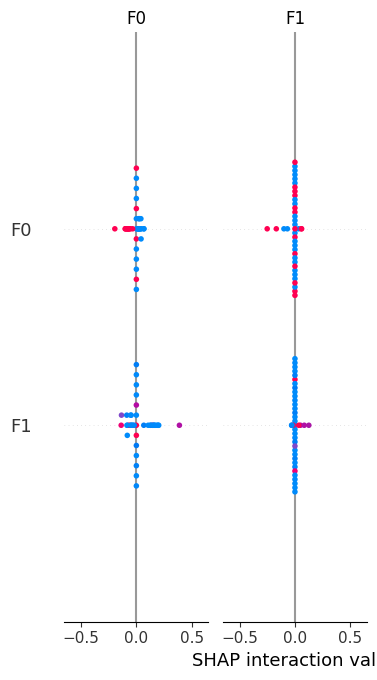


LIME explanation sample 0:


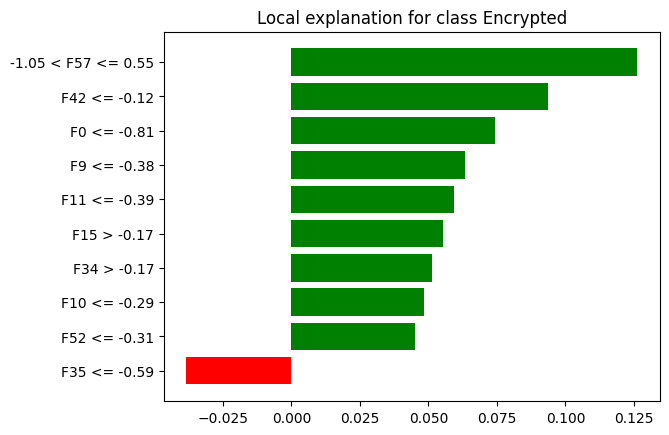


LIME explanation sample 1:


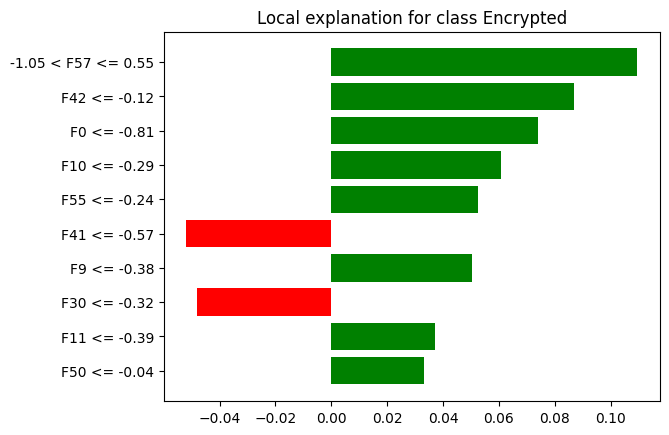


ANALYZING: FGSM
Subset accuracy (200 samples): 0.6000
SHAP: Starting KernelExplainer (this may take time)...


100%|██████████| 40/40 [00:43<00:00,  1.08s/it]

SHAP: computed values shape (40, 62, 2)


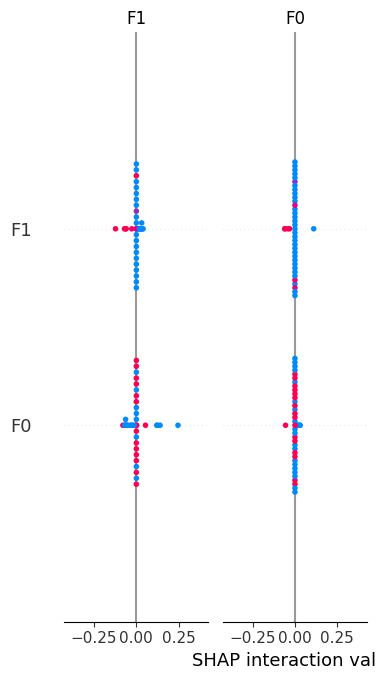


LIME explanation sample 0:
Unable to render LIME figure; printing explanation:


KeyError: 0

In [ ]:
# Fixed, robust SHAP + LIME + plotting pipeline (English)
import numpy as np
import matplotlib.pyplot as plt
import shap
from lime.lime_tabular import LimeTabularExplainer
import tensorflow as tf

# -----------------------------
# Helper: ensure numpy arrays and shapes are correct
# -----------------------------
def to_numpy_array(x):
    if hasattr(x, "numpy"):
        x = x.numpy()
    if isinstance(x, list):
        x = np.asarray(x)
    return x

# Convert inputs to numpy and ensure shapes
X_clean = to_numpy_array(X_test_cnn)            # expected shape: (N, F, 1)
X_fgsm  = to_numpy_array(X_adv_fgsm) if 'X_adv_fgsm' in globals() else to_numpy_array(X_adv_fgsm_np) if 'X_adv_fgsm_np' in globals() else None
X_mi    = to_numpy_array(X_adv_mi)   if 'X_adv_mi' in globals()   else to_numpy_array(X_adv_mi_np)   if 'X_adv_mi_np' in globals()   else None
y_clean = to_numpy_array(y_test_np).reshape(-1)  # (N,)

# Basic sanity checks
if X_clean.ndim != 3 or X_clean.shape[2] != 1:
    raise ValueError(f"X_clean must be (N, F, 1). Found shape: {X_clean.shape}")

feature_dim = X_clean.shape[1]
print(f"Using feature_dim = {feature_dim}. Clean shape: {X_clean.shape}")

# Make sure adversarial arrays if present match shape
for name, arr in [('FGSM', X_fgsm), ('MI', X_mi)]:
    if arr is not None:
        arr = to_numpy_array(arr)
        if arr.ndim == 3 and arr.shape[2] == 1:
            pass
        elif arr.ndim == 2 and arr.shape[1] == feature_dim:
            # assume flattened -> reshape to (N, F, 1)
            arr = arr.reshape(arr.shape[0], feature_dim, 1)
        else:
            raise ValueError(f"{name} adversarial array has unexpected shape: {arr.shape}")
        if name == 'FGSM':
            X_fgsm = arr
        else:
            X_mi = arr

# Build dataset dict for analysis
datasets_dict = {
    'clean': (X_clean, y_clean),
}
if X_fgsm is not None: datasets_dict['fgsm'] = (X_fgsm, y_clean)
if X_mi is not None:   datasets_dict['mi']   = (X_mi,   y_clean)

# -----------------------------
# Prediction wrapper: takes 2D flat input and returns (N,2) probabilities
# -----------------------------
def make_predict_proba_fn(model, feature_dim):
    def predict_proba(X):
        # X may come as (N, F) flattened by explainers -> reshape to CNN input
        X = np.asarray(X)
        if X.ndim == 2:
            X_reshaped = X.reshape(-1, feature_dim, 1)
        elif X.ndim == 3:
            X_reshaped = X
        else:
            raise ValueError("predict_proba expects 2D or 3D array")
        probs = model.predict(X_reshaped, verbose=0)
        probs = probs.reshape(-1, 1)
        return np.hstack([1.0 - probs, probs])  # columns: [P(class0), P(class1)]
    return predict_proba

predict_proba_fn = make_predict_proba_fn(cnn, feature_dim)

# -----------------------------
# SHAP analysis (per-dataset). Robust: try KernelExplainer, fallback to gradient-based importance
# -----------------------------
def shap_analysis_for_dataset(model, X_data, feature_names=None, background_size=50, explain_size=40):
    """
    Returns (shap_values, explainer, used_background, used_Xexplained)
    shap_values will be a numpy array or None on failure.
    """
    X_flat = X_data.reshape(X_data.shape[0], -1)  # (N, F)
    n_bg = min(background_size, X_flat.shape[0])
    n_explain = min(explain_size, X_flat.shape[0])

    background = X_flat[np.random.choice(X_flat.shape[0], n_bg, replace=False)]
    to_explain = X_flat[:n_explain]

    # Try KernelExplainer (model-agnostic, stable if correct wrapper)
    try:
        print("SHAP: Starting KernelExplainer (this may take time)...")
        ke = shap.KernelExplainer(predict_proba_fn, background)
        # compute shap values for the positive class (class 1). KernelExplainer returns list per output;
        shap_vals = ke.shap_values(to_explain, nsamples=200)  # nsamples tradeoff: larger->more accurate
        # For binary, shap_values may be list; take second (class1) if so.
        if isinstance(shap_vals, list) and len(shap_vals) == 2:
            shap_vals = np.asarray(shap_vals[1])
        shap_vals = np.asarray(shap_vals)  # shape (n_explain, F)
        print(f"SHAP: computed values shape {shap_vals.shape}")
        return shap_vals, ke, background, to_explain
    except Exception as e:
        print(f"[SHAP KernelExplainer failed] {e}")
        print("Falling back to gradient-based approximate importance (fast).")

        # Fallback: gradient magnitude averaged across samples (local approx)
        grads = []
        for i in range(min(20, X_data.shape[0])):
            x = tf.convert_to_tensor(X_data[i:i+1], dtype=tf.float32)
            with tf.GradientTape() as tape:
                tape.watch(x)
                p = model(x, training=False)
                # choose positive class prob as scalar
                loss = tf.keras.losses.binary_crossentropy(tf.ones_like(p)*0.5, p)
            g = tape.gradient(loss, x)  # shape (1, F, 1)
            grads.append(np.abs(g.numpy()).reshape(-1))
        if len(grads) > 0:
            grads = np.stack(grads, axis=0)   # (samples, F)
            approx_shap = np.mean(grads, axis=0, keepdims=True)  # (1, F)
            return approx_shap, None, background, to_explain

# -----------------------------
# LIME analysis (per-dataset)
# -----------------------------
def lime_analysis_for_dataset(model, X_train_sample, X_to_explain, feature_names=None, num_samples=2, num_features=10):
    """
    X_train_sample: 2D (N_train, F) flattened
    X_to_explain: 2D (N_explain, F) flattened
    """
    # create explainer
    explainer = LimeTabularExplainer(
    training_data=X_train_sample,
    feature_names=feature_names,
    class_names=['Encrypted'],  # ONLY ONE CLASS for sigmoid output
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

    predict_fn = make_predict_proba_fn(model, feature_dim)
    explanations = []
    for i in range(min(num_samples, X_to_explain.shape[0])):
        try:
            exp = explainer.explain_instance(
    data_row=X_to_explain[i],
    predict_fn=predict_proba_fn,
    num_features=num_features,
    top_labels=1  # still okay; LIME will return label 0 only
)

            explanations.append(exp)
        except Exception as e:
            print(f"[LIME] failed for sample {i}: {e}")
    return explanations

# -----------------------------
# Visualization helpers
# -----------------------------
def plot_shap_summary(shap_values, X_flat, feature_names, title_prefix=""):
    # shap_values: (n_samples, F)
    if shap_values is None:
        print("No SHAP values to plot.")
        return
    try:
        # Use SHAP's summary_plot
        shap.summary_plot(shap_values, X_flat, feature_names=feature_names, show=True)
    except Exception as e:
        # fallback: plot mean absolute importance
        imp = np.mean(np.abs(shap_values), axis=0)
        idx = np.argsort(imp)[::-1][:20]
        plt.figure(figsize=(8,6))
        plt.barh(np.arange(len(idx))[::-1], imp[idx])
        plt.yticks(np.arange(len(idx)), [feature_names[i] for i in idx[::-1]])
        plt.title(title_prefix + " Mean |SHAP| (top 20)")
        plt.show()

def show_lime(exp):
    # list of existing labels in the explanation
    available_labels = list(exp.local_exp.keys())

    if len(available_labels) == 0:
        print("⚠️ LIME produced no explanation for this sample.")
        print("Usually happens when the model output is constant under perturbations.")
        print("Skipping...")
        return

    label = available_labels[0]   # the only available label (usually 0)

    try:
        fig = exp.as_pyplot_figure(label=label)
        plt.show(fig)
    except Exception:
        # fallback: print text version
        print("⚠️ Plot failed, printing raw explanation:")
        print(exp.as_list(label=label))



# -----------------------------
# Run analysis for each dataset, produce plots
# -----------------------------
feature_names = [f"F{i}" for i in range(feature_dim)]
results = {}

for ds_name, (X_d, y_d) in datasets_dict.items():
    print("\n" + "="*40)
    print(f"ANALYZING: {ds_name.upper()}")
    print("="*40)

    # flatten for explainers
    X_flat = X_d.reshape(X_d.shape[0], -1)

    # accuracy on a subset (to save time)
    preds = predict_proba_fn(X_flat[:200])[:,1]
    preds_label = (preds >= 0.5).astype(int)
    acc = (preds_label == y_d[:len(preds_label)]).mean()
    print(f"Subset accuracy ({min(200, X_d.shape[0])} samples): {acc:.4f}")

    # SHAP
    shap_vals, explainer_obj, background_used, to_explain = shap_analysis_for_dataset(cnn, X_d, feature_names=feature_names)
    plot_shap_summary(shap_vals, to_explain, feature_names, title_prefix=f"{ds_name}: ")
    results[ds_name] = {'accuracy': acc, 'shap_values': shap_vals}

    # LIME - use small training sample and small explain set
    X_train_sample = X_flat[np.random.choice(X_flat.shape[0], min(200, X_flat.shape[0]), replace=False)]
    X_to_explain = X_flat[:5]
    lime_exps = lime_analysis_for_dataset(cnn, X_train_sample, X_to_explain, feature_names=feature_names, num_samples=2)
    for i, exp in enumerate(lime_exps):
        print(f"\nLIME explanation sample {i}:")
        show_lime_explanation(exp)
    results[ds_name]['lime_explanations'] = lime_exps

# -----------------------------
# Comparison plots: accuracy bar
# -----------------------------
plt.figure(figsize=(6,4))
labels = list(results.keys())
accs = [results[k]['accuracy'] for k in labels]
plt.bar(labels, accs, color=['green' if k=='clean' else 'orange' for k in labels])
plt.ylim(0,1)
for i,v in enumerate(accs):
    plt.text(i, v+0.02, f"{v:.3f}", ha='center')
plt.title("Subset Accuracy per Dataset")
plt.show()

# -----------------------------
# Done
# -----------------------------
print("XAI analysis complete. 'results' dict contains shap and lime outputs per dataset.")



ANALYZING: CLEAN
Subset accuracy (200 samples): 0.9550


100%|██████████| 40/40 [00:44<00:00,  1.12s/it]


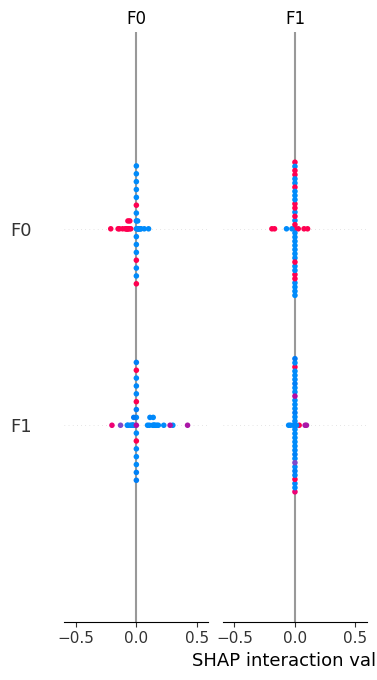


LIME explanation sample 0:


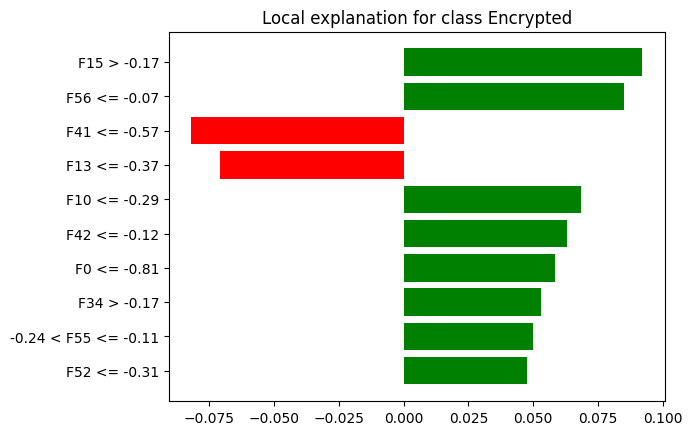


LIME explanation sample 1:


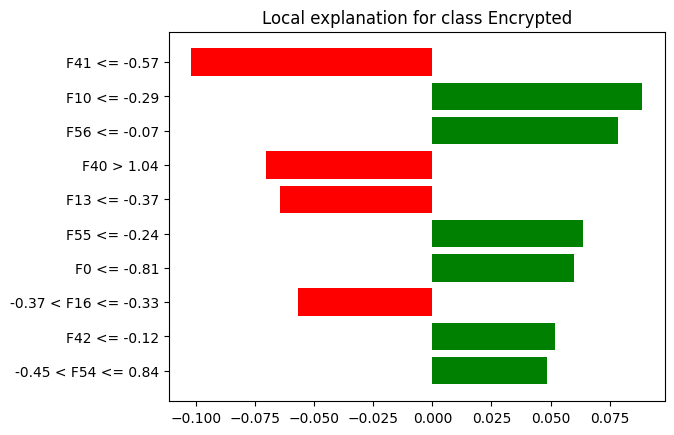


ANALYZING: FGSM
Subset accuracy (200 samples): 0.6000


100%|██████████| 40/40 [00:44<00:00,  1.12s/it]


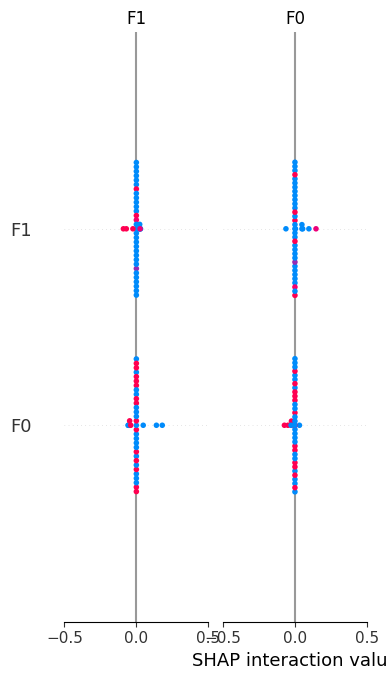


LIME explanation sample 0:
⚠️ Plot failed, printing raw explanation:
[('0.00 < F57 <= 0.60', 0.2051362061353315), ('F60 <= 0.00', 0.13675522324089145), ('F41 <= 0.00', 0.12874580280884773), ('F54 <= 0.00', -0.12627582808662058), ('F16 <= 0.00', 0.12457440947211092), ('F11 <= 0.00', -0.12187651277203256), ('F61 <= 0.00', 0.11706717506055754), ('F12 <= 0.00', -0.1006426004566598), ('F17 <= 0.00', 0.08722867255424145), ('F10 <= 0.00', -0.08305704446575612)]

LIME explanation sample 1:
⚠️ Plot failed, printing raw explanation:
[('0.00 < F57 <= 0.60', 0.2065023137235315), ('F41 <= 0.00', 0.13769703509959486), ('F60 <= 0.00', 0.1224778100522196), ('F54 <= 0.00', -0.1200824736610506), ('F16 <= 0.00', 0.10708081148339385), ('F61 <= 0.00', 0.10642976438460222), ('F11 <= 0.00', -0.09620792446442249), ('F12 <= 0.00', -0.08841746079402683), ('F17 <= 0.00', 0.08560563816237153), ('F10 <= 0.00', -0.07915107630714602)]

ANALYZING: MI
Subset accuracy (200 samples): 0.3800


100%|██████████| 40/40 [00:43<00:00,  1.10s/it]


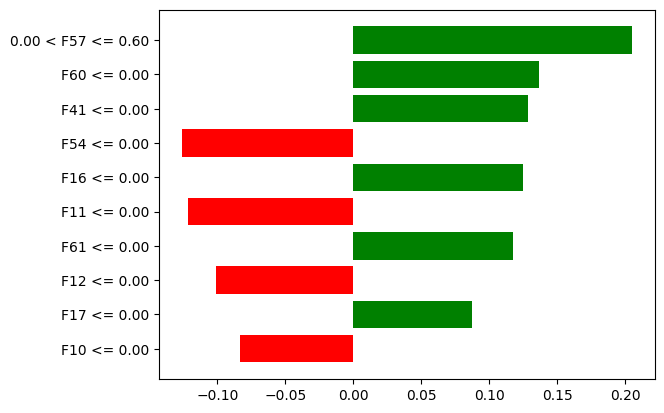

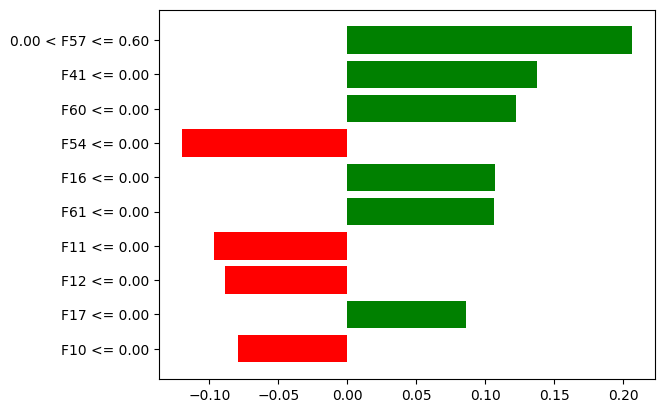

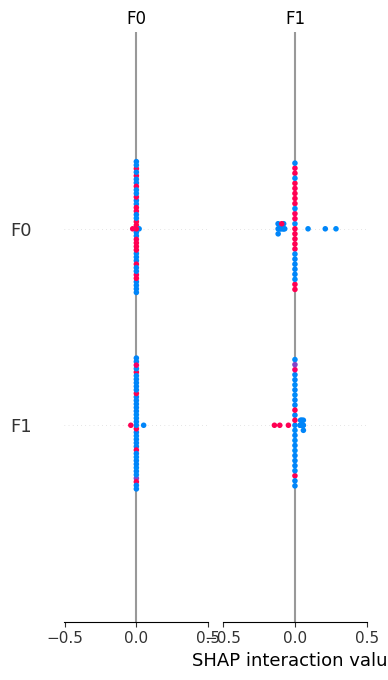


LIME explanation sample 0:
⚠️ Plot failed, printing raw explanation:
[('F61 <= 0.04', 0.12435736969759721), ('F11 <= 0.04', -0.10843669286359967), ('0.00 < F57 <= 0.60', 0.08946253880964866), ('0.00 < F60 <= 0.85', 0.08352131036643995), ('F54 <= 0.00', -0.07440296267783134), ('F34 > 0.04', -0.07065069343926643), ('F2 <= 0.00', 0.0677968062989487), ('0.04 < F40 <= 0.96', -0.056156499896839095), ('0.00 < F12 <= 0.04', -0.04909709416727522), ('F0 <= 0.04', -0.04531041150879867)]

LIME explanation sample 1:
⚠️ Plot failed, printing raw explanation:
[('F11 <= 0.04', -0.09215689258337018), ('F61 <= 0.04', 0.08876477197306022), ('0.00 < F57 <= 0.60', 0.08711593799377275), ('0.00 < F54 <= 0.04', -0.06634343613924548), ('F0 <= 0.04', -0.05903682838277426), ('0.04 < F40 <= 0.96', -0.058496914571642834), ('0.00 < F60 <= 0.85', 0.05824791059938528), ('0.00 < F12 <= 0.04', -0.056749169063156454), ('F2 <= 0.00', 0.048677337289968065), ('F41 <= 0.00', 0.04398566313144354)]


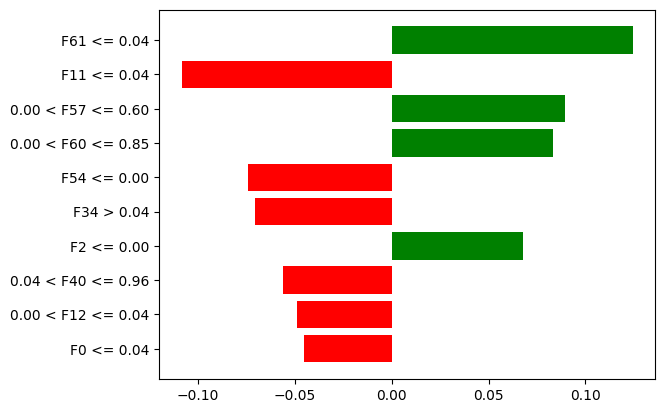

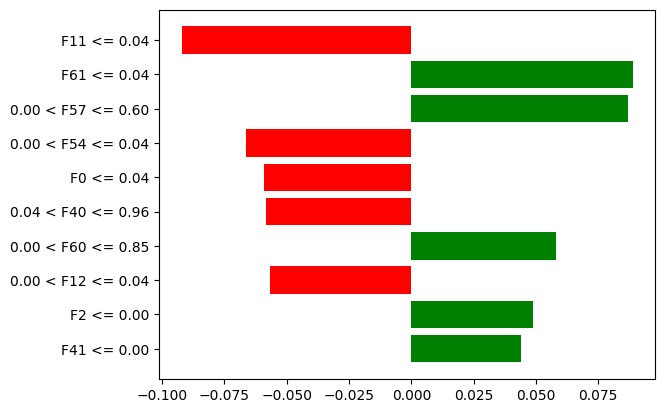

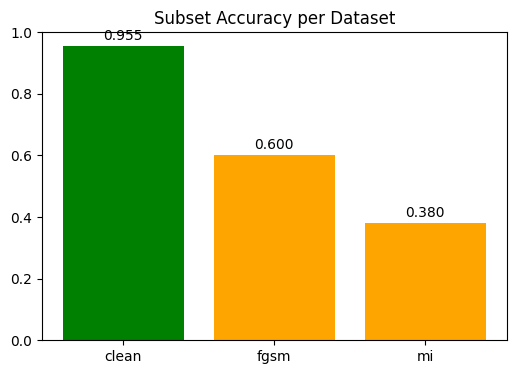

XAI analysis complete. 'results' dict contains shap and lime outputs per dataset.


In [88]:
# ==============================
# Fully Integrated XAI Analysis (SHAP + LIME)
# ==============================
import numpy as np
import matplotlib.pyplot as plt
import shap
from lime.lime_tabular import LimeTabularExplainer
import tensorflow as tf

# -----------------------------
# Helper: convert to numpy array
# -----------------------------
def to_numpy_array(x):
    if hasattr(x, "numpy"):
        x = x.numpy()
    if isinstance(x, list):
        x = np.asarray(x)
    return x

# -----------------------------
# Prepare datasets
# -----------------------------
X_clean = to_numpy_array(X_test_cnn)
X_fgsm  = to_numpy_array(X_adv_fgsm) if 'X_adv_fgsm' in globals() else None
X_mi    = to_numpy_array(X_adv_mi)   if 'X_adv_mi'   in globals() else None
y_clean = to_numpy_array(y_test_np).reshape(-1)

# Sanity check shapes
if X_clean.ndim != 3 or X_clean.shape[2] != 1:
    raise ValueError(f"X_clean must be (N, F, 1). Found shape: {X_clean.shape}")
feature_dim = X_clean.shape[1]

# Ensure adversarial examples have correct shape
for name, arr in [('FGSM', X_fgsm), ('MI', X_mi)]:
    if arr is not None:
        arr = to_numpy_array(arr)
        if arr.ndim == 3 and arr.shape[2] == 1:
            pass
        elif arr.ndim == 2 and arr.shape[1] == feature_dim:
            arr = arr.reshape(arr.shape[0], feature_dim, 1)
        else:
            raise ValueError(f"{name} array has unexpected shape: {arr.shape}")
        if name == 'FGSM': X_fgsm = arr
        if name == 'MI':   X_mi   = arr

# Build dataset dictionary
datasets_dict = {'clean': (X_clean, y_clean)}
if X_fgsm is not None: datasets_dict['fgsm'] = (X_fgsm, y_clean)
if X_mi   is not None: datasets_dict['mi']   = (X_mi,   y_clean)

# -----------------------------
# Prediction wrapper for explainers
# -----------------------------
def make_predict_proba_fn(model, feature_dim):
    def predict_proba(X):
        X = np.asarray(X)
        if X.ndim == 2:
            X_reshaped = X.reshape(-1, feature_dim, 1)
        elif X.ndim == 3:
            X_reshaped = X
        else:
            raise ValueError("predict_proba expects 2D or 3D array")
        probs = model.predict(X_reshaped, verbose=0).reshape(-1,1)
        return np.hstack([1-probs, probs])
    return predict_proba

predict_proba_fn = make_predict_proba_fn(cnn, feature_dim)

# -----------------------------
# SHAP analysis
# -----------------------------
def shap_analysis_for_dataset(model, X_data, feature_names=None, background_size=50, explain_size=40):
    X_flat = X_data.reshape(X_data.shape[0], -1)
    n_bg = min(background_size, X_flat.shape[0])
    n_explain = min(explain_size, X_flat.shape[0])
    background = X_flat[np.random.choice(X_flat.shape[0], n_bg, replace=False)]
    to_explain = X_flat[:n_explain]
    try:
        ke = shap.KernelExplainer(predict_proba_fn, background)
        shap_vals = ke.shap_values(to_explain, nsamples=200)
        if isinstance(shap_vals, list) and len(shap_vals) == 2:
            shap_vals = np.asarray(shap_vals[1])
        shap_vals = np.asarray(shap_vals)
        return shap_vals, ke, background, to_explain
    except Exception as e:
        print(f"[SHAP KernelExplainer failed] {e}")
        grads = []
        for i in range(min(20, X_data.shape[0])):
            x = tf.convert_to_tensor(X_data[i:i+1], dtype=tf.float32)
            with tf.GradientTape() as tape:
                tape.watch(x)
                p = model(x, training=False)
                loss = tf.keras.losses.binary_crossentropy(tf.ones_like(p)*0.5, p)
            g = tape.gradient(loss, x)
            grads.append(np.abs(g.numpy()).reshape(-1))
        if len(grads) > 0:
            grads = np.stack(grads, axis=0)
            approx_shap = np.mean(grads, axis=0, keepdims=True)
            return approx_shap, None, background, to_explain

# -----------------------------
# LIME analysis
# -----------------------------
def lime_analysis_for_dataset(model, X_train_sample, X_to_explain, feature_names=None, num_samples=2, num_features=10):
    explainer = LimeTabularExplainer(
        training_data=X_train_sample,
        feature_names=feature_names,
        class_names=['Encrypted'],
        mode='classification',
        discretize_continuous=True,
        random_state=42
    )
    explanations = []
    for i in range(min(num_samples, X_to_explain.shape[0])):
        try:
            exp = explainer.explain_instance(
                data_row=X_to_explain[i],
                predict_fn=predict_proba_fn,
                num_features=num_features,
                top_labels=1
            )
            explanations.append(exp)
        except Exception as e:
            print(f"[LIME] failed for sample {i}: {e}")
    return explanations

# -----------------------------
# SHAP summary plot helper
# -----------------------------
def plot_shap_summary(shap_values, X_flat, feature_names, title_prefix=""):
    if shap_values is None:
        print("No SHAP values to plot.")
        return
    try:
        shap.summary_plot(shap_values, X_flat, feature_names=feature_names, show=True)
    except Exception as e:
        imp = np.mean(np.abs(shap_values), axis=0)
        idx = np.argsort(imp)[::-1][:20]
        plt.figure(figsize=(8,6))
        plt.barh(np.arange(len(idx))[::-1], imp[idx])
        plt.yticks(np.arange(len(idx)), [feature_names[i] for i in idx[::-1]])
        plt.title(title_prefix + " Mean |SHAP| (top 20)")
        plt.show()

# -----------------------------
# Show LIME helper
# -----------------------------
def show_lime(exp):
    available_labels = list(exp.local_exp.keys())
    if len(available_labels) == 0:
        print("⚠️ LIME produced no explanation for this sample.")
        return
    label = available_labels[0]
    try:
        fig = exp.as_pyplot_figure(label=label)
        plt.show(fig)
    except Exception:
        print("⚠️ Plot failed, printing raw explanation:")
        print(exp.as_list(label=label))

# -----------------------------
# Run analysis
# -----------------------------
feature_names = [f"F{i}" for i in range(feature_dim)]
results = {}

for ds_name, (X_d, y_d) in datasets_dict.items():
    print("\n" + "="*40)
    print(f"ANALYZING: {ds_name.upper()}")
    print("="*40)

    X_flat = X_d.reshape(X_d.shape[0], -1)
    preds = predict_proba_fn(X_flat[:200])[:,1]
    preds_label = (preds >= 0.5).astype(int)
    acc = (preds_label == y_d[:len(preds_label)]).mean()
    print(f"Subset accuracy ({min(200, X_d.shape[0])} samples): {acc:.4f}")

    # SHAP
    shap_vals, explainer_obj, bg_used, to_explain = shap_analysis_for_dataset(cnn, X_d, feature_names=feature_names)
    plot_shap_summary(shap_vals, to_explain, feature_names, title_prefix=f"{ds_name}: ")
    results[ds_name] = {'accuracy': acc, 'shap_values': shap_vals}

    # LIME
    X_train_sample = X_flat[np.random.choice(X_flat.shape[0], min(200, X_flat.shape[0]), replace=False)]
    X_to_explain = X_flat[:5]
    lime_exps = lime_analysis_for_dataset(cnn, X_train_sample, X_to_explain, feature_names=feature_names, num_samples=2)
    for i, exp in enumerate(lime_exps):
        print(f"\nLIME explanation sample {i}:")
        show_lime(exp)
    results[ds_name]['lime_explanations'] = lime_exps

# -----------------------------
# Accuracy comparison plot
# -----------------------------
plt.figure(figsize=(6,4))
labels = list(results.keys())
accs = [results[k]['accuracy'] for k in labels]
plt.bar(labels, accs, color=['green' if k=='clean' else 'orange' for k in labels])
plt.ylim(0,1)
for i,v in enumerate(accs):
    plt.text(i, v+0.02, f"{v:.3f}", ha='center')
plt.title("Subset Accuracy per Dataset")
plt.show()

print("XAI analysis complete. 'results' dict contains shap and lime outputs per dataset.")


In [89]:
import numpy as np
import tensorflow as tf

def pgd_attack(model, X, y=None, eps=0.05, alpha=0.01, steps=10, clip_min=0.0, clip_max=1.0):
    """
    X: (N, F, 1) input tensor/array
    y: labels (optional, used for targeted attack if needed)
    eps: max perturbation
    alpha: step size
    steps: number of iterations
    clip_min/clip_max: valid input range
    """
    X_adv = tf.convert_to_tensor(X, dtype=tf.float32)
    for i in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(X_adv)
            logits = model(X_adv, training=False)
            loss = tf.keras.losses.binary_crossentropy(y if y is not None else tf.ones_like(logits)*0.5, logits)
        grad = tape.gradient(loss, X_adv)
        X_adv = X_adv + alpha * tf.sign(grad)
        X_adv = tf.clip_by_value(X_adv, X - eps, X + eps)  # Project back to eps-ball
        X_adv = tf.clip_by_value(X_adv, clip_min, clip_max)  # Clip to valid range
    return X_adv.numpy()
X_pgd = pgd_attack(cnn, X_clean[:500], y=None, eps=0.05, alpha=0.01, steps=10)
print("PGD adversarial shape:", X_pgd.shape)


PGD adversarial shape: (500, 62, 1)


In [91]:
datasets_dict['pgd'] = (X_pgd, y_clean[:X_pgd.shape[0]])
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Subset for evaluation (optional)
X_eval = X_clean[:500]   # clean samples
y_eval = y_clean[:500]   # true labels

X_adv_eval = X_pgd       # PGD adversarial
# Use your predict_proba wrapper
y_pred_clean_prob = predict_proba_fn(X_eval)[:,1]
y_pred_clean = (y_pred_clean_prob >= 0.5).astype(int)

y_pred_adv_prob = predict_proba_fn(X_adv_eval)[:,1]
y_pred_adv = (y_pred_adv_prob >= 0.5).astype(int)


In [92]:
def evaluate_metrics(y_true, y_pred, y_prob):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    auc  = roc_auc_score(y_true, y_prob)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': auc}

metrics_clean = evaluate_metrics(y_eval, y_pred_clean, y_pred_clean_prob)
metrics_pgd   = evaluate_metrics(y_eval, y_pred_adv, y_pred_adv_prob)

print("=== Clean Accuracy Metrics ===")
print(metrics_clean)
print("\n=== PGD Adversarial Metrics ===")
print(metrics_pgd)


=== Clean Accuracy Metrics ===
{'accuracy': 0.95, 'precision': 0.8676470588235294, 'recall': 0.944, 'f1': 0.9042145593869731, 'roc_auc': 0.9873706666666666}

=== PGD Adversarial Metrics ===
{'accuracy': 0.642, 'precision': 0.36764705882352944, 'recall': 0.6, 'f1': 0.45592705167173253, 'roc_auc': 0.7433066666666666}


In [93]:
def simba_attack(model, X, eps=0.1, n_iters=1000, sample_dim=None, clip_min=0.0, clip_max=1.0):
    """
    X: (N, F, 1)
    eps: step per coordinate
    n_iters: total iterations
    sample_dim: features to perturb at each step (default all)
    """
    X_adv = X.copy()
    N, F, _ = X_adv.shape
    if sample_dim is None:
        sample_dim = F

    # Flatten per sample for coordinate-wise perturbation
    X_flat = X_adv.reshape(N, F)
    
    for i in range(n_iters):
        for j in range(N):
            idx = np.random.randint(0, F)  # random feature
            delta = np.zeros(F)
            delta[idx] = eps
            # Try positive perturbation
            pred_plus = model.predict(X_flat[j:j+1].reshape(1,F,1), verbose=0)
            pred_minus = model.predict((X_flat[j:j+1] - delta).reshape(1,F,1), verbose=0)
            pred_orig  = model.predict(X_flat[j:j+1].reshape(1,F,1), verbose=0)
            # Decide direction
            if pred_plus[0,0] > pred_orig[0,0]:
                X_flat[j, idx] += eps
            elif pred_minus[0,0] > pred_orig[0,0]:
                X_flat[j, idx] -= eps
            # Clip
            X_flat[j] = np.clip(X_flat[j], clip_min, clip_max)
    return X_flat.reshape(N, F, 1)


In [ ]:
# -----------------------------
# 1️⃣ Subset for evaluation
# -----------------------------
subset_size = 500
X_eval = X_clean[:subset_size]
y_eval = y_clean[:subset_size]

# -----------------------------
# 2️⃣ Clean predictions
# -----------------------------
y_pred_clean_prob = predict_proba_fn(X_eval)[:,1]
y_pred_clean = (y_pred_clean_prob >= 0.5).astype(int)

# -----------------------------
# 3️⃣ Generate SIMBA adversarial examples
# -----------------------------
X_simba = X_eval.copy()

# Remove `y` argument — just pass model and inputs
X_adv_simba = simba_attack(model=cnn, X=X_simba)  # adjust kwargs if your function needs iterations, eps, etc.

# -----------------------------
# 4️⃣ Predictions on SIMBA examples
# -----------------------------
y_pred_simba_prob = predict_proba_fn(X_adv_simba)[:,1]
y_pred_simba = (y_pred_simba_prob >= 0.5).astype(int)

# -----------------------------
# 5️⃣ Compute metrics
# -----------------------------
metrics_clean = evaluate_metrics(y_eval, y_pred_clean, y_pred_clean_prob)
metrics_simba = evaluate_metrics(y_eval, y_pred_simba, y_pred_simba_prob)

print("=== Clean Accuracy Metrics ===")
print(metrics_clean)
print("\n=== SIMBA Accuracy Metrics ===")
print(metrics_simba)


In [95]:
# Clean predictions
y_pred_clean_prob = predict_proba_fn(X_eval)[:,1]
y_pred_clean = (y_pred_clean_prob >= 0.5).astype(int)

# SIMBA predictions
y_pred_simba_prob = predict_proba_fn(X_adv_simba)[:,1]
y_pred_simba = (y_pred_simba_prob >= 0.5).astype(int)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_metrics(y_true, y_pred, y_prob):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    auc  = roc_auc_score(y_true, y_prob)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': auc}
